# ITERACIONES: **2.5. Clustering de productos: comparativa de técnicas de análisis clúster.**



**Propósito.**  
Validar la robustez del clustering aplicado al catálogo de productos comparándolo con técnicas alternativas. El objetivo no es sustituir el método actual por defecto, sino **comprobar si K-Means es adecuado** para nuestros datos o si existe una alternativa que aporte **mejor separación/cohesión** y/o **mejor interpretabilidad**.


## Datos de entrada

- **Dataset**: `data/processed/productos_features_norm.csv`  
  (variables numéricas ya estandarizadas: `d_total`, `d_media`, `d_std`, `cv`, `p95`, `mediana`, `precio_medio`, `PC1`, `PC2`, `PC3`; `Product_ID` como identificador).
- Razón de uso: todas las técnicas se benefician de trabajar en la misma escala; garantiza comparabilidad.



## Metodología de comparación

1. **Baseline (Iteración 0): K-Means (k=4)**  
   Partimos de los resultados ya obtenidos (inercia y silhouette vs. *k*, asignación final). Esta iteración sirve de referencia para la comparativa.

2. **Técnicas alternativas**
   - **Iteración 1: Agglomerative Clustering (jerárquico)**  
     Enlace *ward* sobre distancia euclidiana (coherente con datos normalizados). Se evaluarán varios *k*.
   - **Iteración 2: Gaussian Mixture Models (GMM)**  
     Enfoque probabilístico; permite solapamiento entre clusters. Se evaluarán varios *k* y tipos de covarianzas.
   - **Iteración 3: DBSCAN**  
     Clustering basado en densidad; útil para detectar outliers o grupos no esféricos (sin fijar *k*). Se explorarán pares `(eps, min_samples)` razonables.

3. **Métricas de evaluación (internas)**
   - **Silhouette score** (↑ mejor): cohesión intra-cluster y separación inter-cluster.
   - **Davies-Bouldin index** (↓ mejor): ratio de dispersión intra + distancia inter.
   - **Tamaños de cluster**: evitar clusters triviales (muy pequeños) o dominantes excesivos.
   - (Opcional) **Calinski-Harabasz** (↑ mejor): varianza inter/intra.

> Nota: La comparación se centrará en métricas internas (no hay etiquetas “verdaderas”). La **validación de negocio** e **interpretabilidad** se hará en la fase de conclusiones.



## Estructura del cuaderno

- **Iteración 0 — Baseline K-Means**  
  Resumen de resultados (k seleccionado, silhouette, distribución de tamaños).
- **Iteración 1 — Agglomerative**  
  Exploración por *k*: métricas + distribución de tamaños.
- **Iteración 2 — GMM**  
  Exploración por *k* y covarianzas: métricas + distribución de tamaños.
- **Iteración 3 — DBSCAN**  
  Exploración de `(eps, min_samples)`: métricas + tamaños (incluyendo ruido).
- **Tabla comparativa final**  
  Resumen de todas las técnicas/hiperparámetros con métricas lado a lado.
- **Conclusiones**  
  - ¿K-Means es suficiente o hay alternativa superior?  
  - ¿Los resultados son estables y útiles para negocio?  
  - **Decisión**: técnica seleccionada para el proyecto.  
  - Si procede, **siguientes pasos** (crear script definitivo con la técnica elegida).


## Criterios de decisión

1. **Métricas internas**: mejor *silhouette*, menor *Davies-Bouldin* (y, opcionalmente, mayor *Calinski-Harabasz*).  
2. **Estructura razonable**: tamaños de cluster no extremos y sin clusters “vacíos”.  
3. **Parquedad**: preferencia por modelos simples si el rendimiento es similar.  


## Resultados esperados

- Evidencia cuantitativa (gráficas/tablas) que **confirme o refute** la idoneidad de K-Means.  
- Recomendación final y, en su caso, **técnica definitiva** a implementar en script de producción.

> Este cuaderno no genera scripts por iteración. Si se decide cambiar la técnica, se implementará un **único script definitivo** con el algoritmo seleccionado.


## 1.  **Iteración 0.** 
#### ***Baseline K-Means***


In [ ]:

# Script: clustering_productos.py
# ============================================================================

from pathlib import Path
import sys, argparse, logging
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --------------------------- Raíz del proyecto ------------------------------
def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------- Logging ----------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("clustering_productos")

# --- Parche Jupyter: elimina --f=... del kernel para argparse ---------------
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]
# ----------------------------------------------------------------------------

# ------------------------------- Utilidades ---------------------------------
NUM_COLS = [
    "d_total", "d_media", "d_std", "cv", "p95", "mediana",
    "precio_medio", "PC1", "PC2", "PC3"
]

def _check_columns(df: pd.DataFrame, cols: list[str]):
    faltan = [c for c in cols if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en el dataset de entrada: {faltan}")

def _sample_for_silhouette(X: np.ndarray, max_n: int, random_state: int = 42):
    n = X.shape[0]
    if n <= max_n:
        return X, np.arange(n)
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=max_n, replace=False)
    return X[idx], idx

# ---------------------------------- Core ------------------------------------
def explorar_y_clusterizar(in_path: Path,
                           out_path: Path,
                           k_min: int = 3,
                           k_max: int = 10,
                           force_k: int | None = None,
                           sil_sample: int = 5000,
                           random_state: int = 42,
                           n_init: int = 20):

    # 1) Cargar dataset normalizado
    in_path  = Path(in_path)
    out_path = Path(out_path)
    logger.info(f"Cargando features normalizadas: {in_path}")
    df = pd.read_csv(in_path)

    if "Product_ID" not in df.columns:
        raise KeyError("Se requiere columna 'Product_ID' en el dataset de entrada.")
    _check_columns(df, NUM_COLS)

    X = df[NUM_COLS].astype(float).values
    n, d = X.shape
    logger.info(f"Dimensiones: n={n}, d={d}")

    # 2) Explorar rango de k (si no se fuerza)
    ks = list(range(max(2, k_min), max(k_min, k_max) + 1))
    res_inercia = []
    res_sil = []

    for k in ks:
        logger.info(f"[Exploración] Ajustando KMeans con k={k} ...")
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(X)
        inertia = float(km.inertia_)
        res_inercia.append({"k": k, "inercia": inertia})

        # Silhouette (requiere k>=2, ya garantizado) — muestreo opcional por eficiencia
        X_sil, idx_sil = _sample_for_silhouette(X, max_n=sil_sample, random_state=random_state)
        lab_sil = labels[idx_sil]
        try:
            sil = float(silhouette_score(X_sil, lab_sil, metric="euclidean"))
        except Exception as e:
            logger.warning(f"Silhouette falló para k={k}: {e}")
            sil = np.nan
        res_sil.append({"k": k, "silhouette": sil})

    df_inercia = pd.DataFrame(res_inercia)
    df_sil = pd.DataFrame(res_sil)

    # Guardar reportes
    path_inercia = REPORTS_DIR / "inercia_vs_k.csv"
    path_sil = REPORTS_DIR / "silhouette_vs_k.csv"
    df_inercia.to_csv(path_inercia, index=False)
    df_sil.to_csv(path_sil, index=False)
    logger.info(f"Guardado: {path_inercia}")
    logger.info(f"Guardado: {path_sil}")

    # 3) Selección de k
    if force_k is not None:
        best_k = int(force_k)
        logger.info(f"Usando k forzado por CLI: k={best_k}")
    else:
        # Elegir k por máximo silhouette (ignorando NaN); si empate, el menor k
        df_sil_valid = df_sil.dropna(subset=["silhouette"])
        if df_sil_valid.empty:
            # fallback: si no hay silhouette válido, usar punto medio del rango
            best_k = int(np.median(ks))
            logger.warning(f"No se pudo calcular silhouette; usando k={best_k} (mediana del rango).")
        else:
            max_sil = df_sil_valid["silhouette"].max()
            candidatos = df_sil_valid.loc[df_sil_valid["silhouette"] == max_sil, "k"].tolist()
            best_k = min(candidatos)
            logger.info(f"Selección automática por silhouette: k={best_k} (silhouette={max_sil:.4f})")

    # 4) Modelo final con best_k
    logger.info(f"Ajustando modelo final KMeans con k={best_k} ...")
    km_final = KMeans(n_clusters=best_k, random_state=random_state, n_init=n_init)
    labels_final = km_final.fit_predict(X)

    # Validación silhouette final (completo o muestreado si es muy grande)
    X_sil_final, idx_sil_final = _sample_for_silhouette(X, max_n=sil_sample, random_state=random_state)
    lab_sil_final = labels_final[idx_sil_final]
    try:
        sil_final = float(silhouette_score(X_sil_final, lab_sil_final, metric="euclidean"))
    except Exception as e:
        logger.warning(f"Silhouette final falló para k={best_k}: {e}")
        sil_final = np.nan

    # 5) Distribución de tamaños de cluster
    _, counts = np.unique(labels_final, return_counts=True)
    dist_sizes = {int(i): int(c) for i, c in enumerate(counts)}
    min_size = counts.min()
    logger.info("=== VALIDACIÓN CLUSTERING ===")
    logger.info(f"k final: {best_k}")
    logger.info(f"Silhouette (final): {sil_final:.4f}" if not np.isnan(sil_final) else "Silhouette (final): NaN")
    logger.info(f"Tamaños de cluster: {dist_sizes} (min={min_size})")

    # 6) Export asignaciones
    df_clusters = df.copy()
    df_clusters["Cluster"] = labels_final
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_clusters.to_csv(out_path, index=False)
    logger.info(f"Guardado dataset con clusters: {out_path} (filas={len(df_clusters)}, cols={df_clusters.shape[1]})")

    # 7) Devolver info clave
    return {
        "k_final": best_k,
        "silhouette_final": sil_final,
        "sizes": dist_sizes,
        "paths": {
            "clusters": str(out_path),
            "inercia_vs_k": str(path_inercia),
            "silhouette_vs_k": str(path_sil),
        },
    }

# ------------------------------------ CLI -----------------------------------
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Clustering de productos (K-Means) con exploración de k e informes.")
    p.add_argument("--in",       dest="inp",  type=str, default=str(PROCESSED_DIR / "productos_features_norm.csv"))
    p.add_argument("--out",      dest="outp", type=str, default=str(PROCESSED_DIR / "productos_clusters.csv"))
    p.add_argument("--k-min",    dest="kmin", type=int, default=3)
    p.add_argument("--k-max",    dest="kmax", type=int, default=10)
    p.add_argument("--force-k",  dest="kforce", type=int, default=None, help="Forzar k concreto. Si se indica, salta la selección automática.")
    p.add_argument("--sil-sample", dest="silsample", type=int, default=5000,
                   help="Máximo de observaciones para calcular silhouette (muestreo aleatorio si N>valor).")
    p.add_argument("--seed",     dest="seed", type=int, default=42)
    p.add_argument("--n-init",   dest="ninit", type=int, default=20)

    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []

    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | out=%s | k=[%d..%d] | force_k=%s | sil_sample=%d | seed=%d | n_init=%d",
                args.inp, args.outp, args.kmin, args.kmax, str(args.kforce), args.silsample, args.seed, args.ninit)
    return args

def main():
    args = parse_args()
    try:
        info = explorar_y_clusterizar(
            in_path=Path(args.inp),
            out_path=Path(args.outp),
            k_min=args.kmin,
            k_max=args.kmax,
            force_k=args.kforce,
            sil_sample=args.silsample,
            random_state=args.seed,
            n_init=args.ninit
        )
        logger.info("Proceso finalizado. k_final=%s | silhouette_final=%s", info["k_final"], info["silhouette_final"])
        logger.info("Rutas: %s", info["paths"])
    except Exception as e:
        logging.exception(f"Error en clustering: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()


2025-08-28 13:41:31 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv | out=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters.csv | k=[3..10] | force_k=None | sil_sample=5000 | seed=42 | n_init=20
2025-08-28 13:41:31 | INFO | Cargando features normalizadas: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv
2025-08-28 13:41:31 | INFO | Dimensiones: n=5938, d=10
2025-08-28 13:41:31 | INFO | [Exploración] Ajustando KMeans con k=3 ...
2025-08-28 13:41:34 | INFO | [Exploración] Ajustando KMeans con k=4 ...
2025-08-28 13:41:34 | INFO | [Exploración] Ajustando KMeans con k=5 ...
2025-08-28 13:41:34 | INFO | [Exploración] Ajustando KMeans con k=6 ...
2025-08-28 13:41:35 | INFO | [Exploración] Ajustando KMeans con k=7 ...
2025-08-28 


## 2.  **Iteración 1.** 
#### ***Agglomerative Clustering***



🔍 **En qué consiste la técnica**
El **clustering aglomerativo** es un método jerárquico que parte de la idea opuesta a K-Means:  
- Cada producto comienza en su propio cluster.  
- En cada paso, se fusionan los dos clusters más similares según una métrica de distancia y un criterio de enlace.  
- El proceso continúa hasta formar el número deseado de clusters (*k*).  

El criterio utilizado en este caso es el **enlace Ward**, que fusiona clusters minimizando la varianza interna. Esto lo hace especialmente adecuado para datos previamente normalizados.


🧩 **Cómo funciona el script**
El script `clustering_productos_agglomerative.py` ejecuta los siguientes pasos:

1. **Entrada**  
   - Lee el dataset `productos_features_norm.csv`.  
   - Utiliza las variables numéricas normalizadas como base para el clustering.

2. **Exploración de *k***  
   - Ajusta modelos de Agglomerative Clustering para distintos valores de *k* en un rango definido (por defecto 3 a 10).  
   - Calcula métricas internas de validación para cada *k*:  
     - **Silhouette score** (↑ mejor).  
     - **Davies–Bouldin index (DBI)** (↓ mejor).  
     - **Calinski–Harabasz (CH)** (↑ mejor).

3. **Selección del número de clusters**  
   - Elige el *k* con mejor **Silhouette score** (o se puede forzar un valor específico desde CLI).  

4. **Entrenamiento final y salida**  
   - Ajusta el modelo final con el *k* seleccionado.  
   - Asigna un cluster a cada producto, añadiendo la columna `Cluster_Agglo`.  
   - Exporta resultados y reportes:  
     - `productos_clusters_agglom.csv` con las asignaciones.  
     - `silhouette_vs_k_agglom.csv`, `davies_bouldin_vs_k_agglom.csv` y `calinski_harabasz_vs_k_agglom.csv` con métricas de exploración.  


🎯 **Objetivo de esta iteración**
Comparar el rendimiento de **Agglomerative Clustering** frente al baseline de K-Means:  
- Ver si obtiene clusters con mejor cohesión/separación (Silhouette ↑, DBI ↓).  
- Evaluar la estabilidad y distribución de tamaños.  
- Comprobar si la estructura jerárquica revela patrones diferentes o más interpretables que K-Means.


In [2]:
# ============================================================================
# Script: clustering_productos_agglomerative.py
# ============================================================================

from pathlib import Path
import sys, argparse, logging
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --------------------------- Raíz del proyecto ------------------------------
def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------- Logging ----------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("clustering_agglomerative")

# --- Parche Jupyter: elimina --f=... del kernel para argparse ---------------
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]
# ----------------------------------------------------------------------------

NUM_COLS = [
    "d_total", "d_media", "d_std", "cv", "p95", "mediana",
    "precio_medio", "PC1", "PC2", "PC3"
]

def _check_columns(df: pd.DataFrame, cols: list[str]):
    faltan = [c for c in cols if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en el dataset de entrada: {faltan}")

def _fit_predict_agglomerative(X: np.ndarray, k: int, linkage: str, metric: str):
    # Nota: linkage='ward' requiere metric='euclidean' en sklearn.
    if linkage == "ward" and metric != "euclidean":
        metric = "euclidean"
    model = AgglomerativeClustering(
        n_clusters=k, linkage=linkage, metric=metric
    )
    labels = model.fit_predict(X)
    return labels

def explorar_y_clusterizar(in_path: Path,
                           out_path: Path,
                           k_min: int = 3,
                           k_max: int = 10,
                           force_k: int | None = None,
                           linkage: str = "ward",
                           metric: str = "euclidean",
                           sil_sample: int = 7000,
                           random_state: int = 42):
    # 1) Cargar
    in_path  = Path(in_path)
    out_path = Path(out_path)
    logger.info(f"Cargando features normalizadas: {in_path}")
    df = pd.read_csv(in_path)

    if "Product_ID" not in df.columns:
        raise KeyError("Se requiere columna 'Product_ID' en el dataset de entrada.")
    _check_columns(df, NUM_COLS)

    X = df[NUM_COLS].astype(float).values
    n = X.shape[0]
    rng = np.random.default_rng(random_state)

    # 2) Explorar k
    ks = list(range(max(2, k_min), max(k_min, k_max) + 1))
    res_sil, res_dbi, res_ch = [], [], []

    for k in ks:
        logger.info(f"[Exploración] Agglomerative (linkage={linkage}, metric={metric}) con k={k}")
        labels = _fit_predict_agglomerative(X, k, linkage, metric)

        # Silhouette (muestreo si N muy grande)
        if n > sil_sample:
            idx = rng.choice(n, size=sil_sample, replace=False)
            X_s = X[idx]; y_s = labels[idx]
        else:
            X_s, y_s = X, labels

        try:
            sil = float(silhouette_score(X_s, y_s, metric="euclidean"))
        except Exception as e:
            logger.warning(f"Silhouette falló para k={k}: {e}")
            sil = np.nan

        # Davies-Bouldin (↓ mejor) y Calinski-Harabasz (↑ mejor) con todo X (si posible)
        try:
            dbi = float(davies_bouldin_score(X, labels))
        except Exception as e:
            logger.warning(f"Davies-Bouldin falló para k={k}: {e}")
            dbi = np.nan
        try:
            ch = float(calinski_harabasz_score(X, labels))
        except Exception as e:
            logger.warning(f"Calinski-Harabasz falló para k={k}: {e}")
            ch = np.nan

        res_sil.append({"k": k, "silhouette": sil})
        res_dbi.append({"k": k, "davies_bouldin": dbi})
        res_ch.append({"k": k, "calinski_harabasz": ch})

    df_sil = pd.DataFrame(res_sil)
    df_dbi = pd.DataFrame(res_dbi)
    df_ch  = pd.DataFrame(res_ch)

    path_sil = REPORTS_DIR / "silhouette_vs_k_agglom.csv"
    path_dbi = REPORTS_DIR / "davies_bouldin_vs_k_agglom.csv"
    path_ch  = REPORTS_DIR / "calinski_harabasz_vs_k_agglom.csv"
    df_sil.to_csv(path_sil, index=False)
    df_dbi.to_csv(path_dbi, index=False)
    df_ch.to_csv(path_ch, index=False)
    logger.info(f"Guardado: {path_sil}")
    logger.info(f"Guardado: {path_dbi}")
    logger.info(f"Guardado: {path_ch}")

    # 3) Selección de k
    if force_k is not None:
        best_k = int(force_k)
        logger.info(f"Usando k forzado por CLI: k={best_k}")
    else:
        df_sil_valid = df_sil.dropna(subset=["silhouette"])
        if df_sil_valid.empty:
            best_k = int(np.median(ks))
            logger.warning(f"No hay silhouette válido; usando k={best_k} (mediana del rango).")
        else:
            max_sil = df_sil_valid["silhouette"].max()
            candidatos = df_sil_valid.loc[df_sil_valid["silhouette"] == max_sil, "k"].tolist()
            best_k = min(candidatos)
            logger.info(f"Selección automática por silhouette: k={best_k} (silhouette={max_sil:.4f})")

    # 4) Modelo final con best_k
    labels_final = _fit_predict_agglomerative(X, best_k, linkage, metric)

    # Métricas finales
    try:
        sil_final = float(silhouette_score(X if n <= sil_sample else X[rng.choice(n, sil_sample, replace=False)],
                                           labels_final if n <= sil_sample else labels_final[rng.choice(n, sil_sample, replace=False)],
                                           metric="euclidean"))
    except Exception:
        sil_final = np.nan
    try:
        dbi_final = float(davies_bouldin_score(X, labels_final))
    except Exception:
        dbi_final = np.nan
    try:
        ch_final = float(calinski_harabasz_score(X, labels_final))
    except Exception:
        ch_final = np.nan

    # Distribución tamaños
    _, counts = np.unique(labels_final, return_counts=True)
    dist_sizes = {int(i): int(c) for i, c in enumerate(counts)}
    logger.info("=== VALIDACIÓN CLUSTERING (AGGLOMERATIVE) ===")
    logger.info(f"k final: {best_k} | linkage: {linkage} | metric: {metric}")
    logger.info(f"Silhouette final       : {sil_final:.4f}" if not np.isnan(sil_final) else "Silhouette final: NaN")
    logger.info(f"Davies-Bouldin final  : {dbi_final:.4f}" if not np.isnan(dbi_final) else "Davies-Bouldin final: NaN")
    logger.info(f"Calinski-Harabasz final: {ch_final:.2f}" if not np.isnan(ch_final) else "Calinski-Harabasz final: NaN")
    logger.info(f"Tamaños de cluster     : {dist_sizes} (min={counts.min()})")

    # 5) Export asignaciones
    df_out = df.copy()
    df_out["Cluster_Agglo"] = labels_final
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_out.to_csv(out_path, index=False)
    logger.info(f"Guardado dataset con clusters (agglomerative): {out_path} (filas={len(df_out)})")

    return {
        "k_final": best_k,
        "linkage": linkage,
        "metric": metric,
        "silhouette_final": sil_final,
        "davies_bouldin_final": dbi_final,
        "calinski_harabasz_final": ch_final,
        "sizes": dist_sizes,
        "paths": {
            "clusters": str(out_path),
            "silhouette_vs_k": str(path_sil),
            "davies_bouldin_vs_k": str(path_dbi),
            "calinski_harabasz_vs_k": str(path_ch),
        },
    }

# ------------------------------------ CLI -----------------------------------
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Clustering aglomerativo con exploración de k y validación interna.")
    p.add_argument("--in",       dest="inp",   type=str, default=str(PROCESSED_DIR / "productos_features_norm.csv"))
    p.add_argument("--out",      dest="outp",  type=str, default=str(PROCESSED_DIR / "productos_clusters_agglom.csv"))
    p.add_argument("--k-min",    dest="kmin",  type=int, default=3)
    p.add_argument("--k-max",    dest="kmax",  type=int, default=10)
    p.add_argument("--force-k",  dest="kforce", type=int, default=None)
    p.add_argument("--linkage",  dest="linkage", type=str, default="ward", choices=["ward","average","complete","single"])
    p.add_argument("--metric",   dest="metric",  type=str, default="euclidean",
                   help="Distancia para enlaces != ward. Con ward se forzará 'euclidean'.")
    p.add_argument("--sil-sample", dest="silsample", type=int, default=7000)
    p.add_argument("--seed",     dest="seed",   type=int, default=42)

    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []

    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | out=%s | k=[%d..%d] | force_k=%s | linkage=%s | metric=%s | sil_sample=%d",
                args.inp, args.outp, args.kmin, args.kmax, str(args.kforce), args.linkage, args.metric, args.silsample)
    return args

def main():
    args = parse_args()
    try:
        info = explorar_y_clusterizar(
            in_path=Path(args.inp),
            out_path=Path(args.outp),
            k_min=args.kmin,
            k_max=args.kmax,
            force_k=args.kforce,
            linkage=args.linkage,
            metric=args.metric,
            sil_sample=args.silsample,
            random_state=args.seed,
        )
        logger.info("Proceso finalizado. k_final=%s | silhouette=%s | dbi=%s | ch=%s",
                    info["k_final"], info["silhouette_final"], info["davies_bouldin_final"], info["calinski_harabasz_final"])
        logger.info("Rutas: %s", info["paths"])
    except Exception as e:
        logging.exception(f"Error en clustering aglomerativo: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()


2025-08-28 16:02:30 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv | out=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_agglom.csv | k=[3..10] | force_k=None | linkage=ward | metric=euclidean | sil_sample=7000
2025-08-28 16:02:30 | INFO | Cargando features normalizadas: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv
2025-08-28 16:02:30 | INFO | [Exploración] Agglomerative (linkage=ward, metric=euclidean) con k=3
2025-08-28 16:02:31 | INFO | [Exploración] Agglomerative (linkage=ward, metric=euclidean) con k=4
2025-08-28 16:02:32 | INFO | [Exploración] Agglomerative (linkage=ward, metric=euclidean) con k=5
2025-08-28 16:02:33 | INFO | [Exploración] Agglomerative (linkage=ward, metric=euclidean) con k=6
2025-08-28 16:0


 📊 **Resumen de métricas**
- **Número de clusters seleccionado (k):** 4  
- **Silhouette final:** 0.3226  
- **Distribución de tamaños:**  
  - Cluster 0 → 210 productos  
  - Cluster 1 → 1233 productos  
  - Cluster 2 → 3394 productos  
  - Cluster 3 → 1101 productos  
  *(mínimo tamaño: 210 productos)*  
- **Dataset resultante:** `productos_clusters.csv` (5.938 productos × 12 columnas)



 ✅ **Conclusiones**
- El modelo jerárquico (Agglomerative con enlace *ward*) ha seleccionado **k=4**, coincidiendo con el resultado obtenido previamente mediante K-Means.  
- El **silhouette (0.3226)** es prácticamente idéntico al de K-Means, lo que indica que **ambas técnicas ofrecen un nivel de cohesión y separación muy similar**.  
- La distribución de productos por cluster es equilibrada, sin clusters triviales o con tamaños insignificantes, lo que confirma la **robustez de la segmentación**.  
- Dado que los resultados son consistentes entre ambos métodos, se puede concluir que la elección de **K-Means como baseline es válida y no sesgada por la técnica**.  
- No obstante, se recomienda continuar la bitácora con otras técnicas (GMM, DBSCAN) para confirmar que no existen estructuras alternativas con mejor separación o clusters residuales que los métodos actuales no detecten.


## 3.  **Iteración 2.** 
#### ***GMM - Gaussian Mixture Models***


 🔍 **En qué consiste la técnica**
El modelo de **Gaussian Mixture Models (GMM)** asume que los datos provienen de una combinación de varias distribuciones gaussianas (una por cada cluster).  
A diferencia de K-Means o Agglomerative, no asigna cada punto a un cluster de forma rígida, sino que calcula la **probabilidad de pertenencia** de cada producto a cada cluster.  
Esto permite capturar clusters con formas más flexibles (elípticas, solapadas) y detectar casos ambiguos.


🧩️ **Cómo funciona la aproximación**
1. **Entrada**  
   - Dataset `productos_features_norm.csv` con todas las variables numéricas normalizadas.

2. **Entrenamiento GMM**  
   - Se ajustan modelos de mezcla gaussiana para distintos valores de *k*.  
   - Cada cluster se caracteriza por una media y una matriz de covarianzas.  
   - Se probarán diferentes configuraciones de covarianza (`full`, `diag`, `tied`, `spherical`) para evaluar la robustez.

3. **Validación interna**  
   - **Silhouette score** (↑ mejor): evalúa cohesión/separación como en las técnicas previas.  
   - **Davies–Bouldin index (↓ mejor):** evalúa dispersión intra vs separación inter.  
   - **Calinski–Harabasz index (↑ mejor):** evalúa varianza inter/intra.  
   - Se compararán métricas frente a K-Means y Agglomerative.

4. **Selección de *k***  
   - Se propondrá el número de clusters con mejor combinación de métricas.  
   - En caso de empate, se priorizará el modelo más interpretable y estable.



 🎯 **Objetivo de esta iteración**
- Evaluar si un modelo probabilístico como GMM ofrece **mejor separación o interpretabilidad** que los métodos previos.  
- Confirmar si existen clusters solapados que K-Means o Agglomerative no detectaron correctamente.  
- Determinar si la asignación probabilística aporta valor para la segmentación final.



📎 **Resultados esperados**
- Archivos con asignación de clusters (`productos_clusters_gmm.csv`) y métricas comparativas (`silhouette_vs_k_gmm.csv`, `davies_bouldin_vs_k_gmm.csv`, `calinski_harabasz_vs_k_gmm.csv`).  
- Una comparación cuantitativa frente a K-Means y Agglomerative para decidir si GMM mejora la robustez del clustering.


In [1]:

# Script: clustering_productos_gmm.py
# ============================================================================

from pathlib import Path
import sys, argparse, logging
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --------------------------- Raíz del proyecto ------------------------------
def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------- Logging ----------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("clustering_gmm")

# --- Parche Jupyter: elimina --f=... del kernel para argparse ---------------
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]
# ----------------------------------------------------------------------------

NUM_COLS = [
    "d_total", "d_media", "d_std", "cv", "p95", "mediana",
    "precio_medio", "PC1", "PC2", "PC3"
]

def _check_columns(df: pd.DataFrame, cols: list[str]):
    faltan = [c for c in cols if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en el dataset de entrada: {faltan}")

def explorar_y_clusterizar(in_path: Path,
                           out_path: Path,
                           k_min: int = 3,
                           k_max: int = 10,
                           force_k: int | None = None,
                           cov_type: str | None = None,
                           sil_sample: int = 7000,
                           random_state: int = 42,
                           max_iter: int = 500):

    # 1) Cargar dataset
    in_path  = Path(in_path)
    out_path = Path(out_path)
    logger.info(f"Cargando features normalizadas: {in_path}")
    df = pd.read_csv(in_path)

    if "Product_ID" not in df.columns:
        raise KeyError("Se requiere columna 'Product_ID' en el dataset de entrada.")
    _check_columns(df, NUM_COLS)

    X = df[NUM_COLS].astype(float).values
    n = X.shape[0]
    rng = np.random.default_rng(random_state)

    # 2) Definir configuraciones
    ks = list(range(max(2, k_min), max(k_min, k_max) + 1))
    cov_types = [cov_type] if cov_type else ["full", "diag", "tied", "spherical"]

    res_sil, res_dbi, res_ch = [], [], []

    # 3) Exploración
    for k in ks:
        for ct in cov_types:
            logger.info(f"[Exploración] GMM con k={k}, cov_type={ct}")
            gmm = GaussianMixture(
                n_components=k, covariance_type=ct,
                random_state=random_state, max_iter=max_iter
            )
            labels = gmm.fit_predict(X)

            # Silhouette (muestreo si N muy grande)
            if n > sil_sample:
                idx = rng.choice(n, size=sil_sample, replace=False)
                X_s, y_s = X[idx], labels[idx]
            else:
                X_s, y_s = X, labels

            try:
                sil = float(silhouette_score(X_s, y_s, metric="euclidean"))
            except Exception as e:
                logger.warning(f"Silhouette falló (k={k}, cov={ct}): {e}")
                sil = np.nan

            try:
                dbi = float(davies_bouldin_score(X, labels))
            except Exception:
                dbi = np.nan
            try:
                ch = float(calinski_harabasz_score(X, labels))
            except Exception:
                ch = np.nan

            res_sil.append({"k": k, "cov_type": ct, "silhouette": sil})
            res_dbi.append({"k": k, "cov_type": ct, "davies_bouldin": dbi})
            res_ch.append({"k": k, "cov_type": ct, "calinski_harabasz": ch})

    df_sil = pd.DataFrame(res_sil)
    df_dbi = pd.DataFrame(res_dbi)
    df_ch  = pd.DataFrame(res_ch)

    path_sil = REPORTS_DIR / "silhouette_vs_k_gmm.csv"
    path_dbi = REPORTS_DIR / "davies_bouldin_vs_k_gmm.csv"
    path_ch  = REPORTS_DIR / "calinski_harabasz_vs_k_gmm.csv"
    df_sil.to_csv(path_sil, index=False)
    df_dbi.to_csv(path_dbi, index=False)
    df_ch.to_csv(path_ch, index=False)
    logger.info(f"Guardado: {path_sil}")
    logger.info(f"Guardado: {path_dbi}")
    logger.info(f"Guardado: {path_ch}")

    # 4) Selección de mejor modelo
    if force_k is not None:
        best_k = int(force_k)
        best_cov = cov_type if cov_type else "full"
        logger.info(f"Usando k forzado por CLI: k={best_k}, cov={best_cov}")
    else:
        df_sil_valid = df_sil.dropna(subset=["silhouette"])
        if df_sil_valid.empty:
            best_k, best_cov = int(np.median(ks)), "full"
            logger.warning(f"No hay silhouette válido; usando k={best_k}, cov_type={best_cov}")
        else:
            row = df_sil_valid.loc[df_sil_valid["silhouette"].idxmax()]
            best_k, best_cov = int(row["k"]), row["cov_type"]
            logger.info(f"Selección automática: k={best_k}, cov_type={best_cov}, silhouette={row['silhouette']:.4f}")

    # 5) Modelo final
    gmm_final = GaussianMixture(
        n_components=best_k, covariance_type=best_cov,
        random_state=random_state, max_iter=max_iter
    )
    labels_final = gmm_final.fit_predict(X)

    # Métricas finales
    try:
        sil_final = float(silhouette_score(X if n <= sil_sample else X[rng.choice(n, sil_sample, replace=False)],
                                           labels_final if n <= sil_sample else labels_final[rng.choice(n, sil_sample, replace=False)],
                                           metric="euclidean"))
    except Exception:
        sil_final = np.nan
    try:
        dbi_final = float(davies_bouldin_score(X, labels_final))
    except Exception:
        dbi_final = np.nan
    try:
        ch_final = float(calinski_harabasz_score(X, labels_final))
    except Exception:
        ch_final = np.nan

    _, counts = np.unique(labels_final, return_counts=True)
    dist_sizes = {int(i): int(c) for i, c in enumerate(counts)}

    logger.info("=== VALIDACIÓN CLUSTERING (GMM) ===")
    logger.info(f"k final: {best_k} | cov_type: {best_cov}")
    logger.info(f"Silhouette final       : {sil_final:.4f}" if not np.isnan(sil_final) else "Silhouette final: NaN")
    logger.info(f"Davies-Bouldin final  : {dbi_final:.4f}" if not np.isnan(dbi_final) else "Davies-Bouldin final: NaN")
    logger.info(f"Calinski-Harabasz final: {ch_final:.2f}" if not np.isnan(ch_final) else "Calinski-Harabasz final: NaN")
    logger.info(f"Tamaños de cluster     : {dist_sizes} (min={counts.min()})")

    # 6) Export
    df_out = df.copy()
    df_out["Cluster_GMM"] = labels_final
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_out.to_csv(out_path, index=False)
    logger.info(f"Guardado dataset con clusters (GMM): {out_path} (filas={len(df_out)})")

    return {
        "k_final": best_k,
        "cov_type": best_cov,
        "silhouette_final": sil_final,
        "davies_bouldin_final": dbi_final,
        "calinski_harabasz_final": ch_final,
        "sizes": dist_sizes,
        "paths": {
            "clusters": str(out_path),
            "silhouette_vs_k": str(path_sil),
            "davies_bouldin_vs_k": str(path_dbi),
            "calinski_harabasz_vs_k": str(path_ch),
        },
    }

# ------------------------------------ CLI -----------------------------------
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Clustering de productos con Gaussian Mixture Models (GMM).")
    p.add_argument("--in",       dest="inp",   type=str, default=str(PROCESSED_DIR / "productos_features_norm.csv"))
    p.add_argument("--out",      dest="outp",  type=str, default=str(PROCESSED_DIR / "productos_clusters_gmm.csv"))
    p.add_argument("--k-min",    dest="kmin",  type=int, default=3)
    p.add_argument("--k-max",    dest="kmax",  type=int, default=10)
    p.add_argument("--force-k",  dest="kforce", type=int, default=None)
    p.add_argument("--cov-type", dest="covtype", type=str, default=None,
                   choices=["full","diag","tied","spherical"],
                   help="Forzar tipo de covarianza; si no se especifica, se prueban todas.")
    p.add_argument("--sil-sample", dest="silsample", type=int, default=7000)
    p.add_argument("--seed",     dest="seed",   type=int, default=42)
    p.add_argument("--max-iter", dest="maxiter", type=int, default=500)

    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []

    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | out=%s | k=[%d..%d] | force_k=%s | cov_type=%s",
                args.inp, args.outp, args.kmin, args.kmax, str(args.kforce), str(args.covtype))
    return args

def main():
    args = parse_args()
    try:
        info = explorar_y_clusterizar(
            in_path=Path(args.inp),
            out_path=Path(args.outp),
            k_min=args.kmin,
            k_max=args.kmax,
            force_k=args.kforce,
            cov_type=args.covtype,
            sil_sample=args.silsample,
            random_state=args.seed,
            max_iter=args.maxiter,
        )
        logger.info("Proceso finalizado. k_final=%s | cov_type=%s | silhouette=%s | dbi=%s | ch=%s",
                    info["k_final"], info["cov_type"], info["silhouette_final"], info["davies_bouldin_final"], info["calinski_harabasz_final"])
        logger.info("Rutas: %s", info["paths"])
    except Exception as e:
        logging.exception(f"Error en clustering GMM: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()


2025-08-28 18:34:00 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv | out=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_gmm.csv | k=[3..10] | force_k=None | cov_type=None
2025-08-28 18:34:00 | INFO | Cargando features normalizadas: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv
2025-08-28 18:34:00 | INFO | [Exploración] GMM con k=3, cov_type=full
2025-08-28 18:34:02 | INFO | [Exploración] GMM con k=3, cov_type=diag
2025-08-28 18:34:02 | INFO | [Exploración] GMM con k=3, cov_type=tied
2025-08-28 18:34:03 | INFO | [Exploración] GMM con k=3, cov_type=spherical
2025-08-28 18:34:03 | INFO | [Exploración] GMM con k=4, cov_type=full
2025-08-28 18:34:04 | INFO | [Exploración] GMM con k=4, cov_type=diag
2025-08-28 18:34:04 |

✅ **Resultados y conclusiones del clustering con GMM**

Tras ejecutar el algoritmo **Gaussian Mixture Models (GMM)**, los resultados muestran:

- **Número de clusters elegido (k_final): 3**  
  → El modelo encontró que la configuración óptima era con **tres grupos** de productos.

- **Métricas de validación**:  
  - *Silhouette score*: **0.31** → indica una separación moderada entre clusters, algo inferior a K-Means pero aceptable.  
  - *Davies-Bouldin Index (DBI)*: **1.33** → valores más cercanos a 1 sugieren que los clusters están razonablemente compactos y bien separados.  
  - *Calinski-Harabasz (CH)*: **2268** → refleja buena separación inter-cluster en relación con la dispersión intra-cluster.

- **Distribución de tamaños**:  
  - Cluster 0 → 1.385 productos  
  - Cluster 1 → 1.180 productos  
  - Cluster 2 → 3.373 productos  
  → Los tamaños son **equilibrados en comparación con K-Means**, que generaba un cluster muy dominante.



#### Conclusiones
- **GMM ofrece una estructura más flexible** que K-Means, permitiendo asignaciones probabilísticas y mejor adaptación a clusters no esféricos.  
- Aunque la *Silhouette* es algo más baja que con K-Means, los índices *DBI* y *CH* son razonables, lo que indica que los clusters son consistentes.  
- La distribución más equilibrada entre grupos es un punto fuerte de este modelo, evitando concentrar la mayoría de productos en un único cluster.  
- Se recomienda **mantener GMM como modelo alternativo** junto con K-Means y realizar un análisis comparativo de interpretabilidad de los clusters (qué patrones de demanda y precio caracterizan a cada grupo).  




## 4.  **Iteración 3.** 
#### ***DBSCAN***

En esta cuarta aproximación se aplica el algoritmo **DBSCAN** (*Density-Based Spatial Clustering of Applications with Noise*), un método basado en densidad que permite detectar clusters sin necesidad de fijar el número de grupos a priori.

🔑 **Fundamentos de DBSCAN**
- **ε (epsilon):** radio de vecindad que define la proximidad entre puntos.  
- **minPts:** número mínimo de vecinos dentro de ε para que un punto sea considerado "núcleo" (*core point*).  

A partir de estos parámetros, DBSCAN clasifica los puntos en:  
1. **Core points:** puntos con suficiente densidad local (≥ minPts en su radio ε).  
2. **Border points:** puntos que no cumplen la densidad mínima pero se encuentran en el radio de un core.  
3. **Noise points:** puntos que no pertenecen a ningún cluster (outliers).

🧩️ **Funcionamiento aplicado en nuestro caso**
1. Se cargan las features normalizadas de producto (`productos_features_norm.csv`).  
2. Se aplica DBSCAN explorando diferentes combinaciones de parámetros (`ε`, `minPts`) para identificar estructuras densas.  
3. Los productos se asignan a clusters o se marcan como ruido si no cumplen los criterios de densidad.  
4. Se genera un dataset de salida con la asignación de cluster por producto y un reporte de métricas de calidad.  

 **Ventajas**
- Detecta clusters de formas arbitrarias, no restringidos a geometrías esféricas.  
- Identifica **outliers** de forma natural, lo que resulta útil para detectar productos con patrones atípicos.  
- No requiere especificar el número de clusters.  

⚠️ **Limitaciones**
- La elección de `ε` y `minPts` es crítica: valores inadecuados pueden llevar a clusters poco significativos o a exceso de ruido.  
- En datos de alta dimensión, la definición de densidad pierde efectividad.  
- Sensible a la variabilidad de densidad entre clusters.  

 🎯 **Objetivo de esta iteración**
Explorar el potencial de DBSCAN para complementar a K-Means y GMM, verificando si consigue separar subconjuntos atípicos de productos o detectar *outliers* relevantes que puedan distorsionar otros algoritmos de clustering.

In [2]:

# Script: clustering_productos_dbscan.py
# ============================================================================

from pathlib import Path
import sys
import argparse
import logging
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# --------------------------- Raíz del proyecto ------------------------------
def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------- Logging ----------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("clustering_dbscan")

# --- Parche Jupyter: elimina --f=... del kernel para argparse ---------------
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]
# ----------------------------------------------------------------------------

# Variables numéricas esperadas en productos_features_norm.csv
NUM_COLS = [
    "d_total", "d_media", "d_std", "cv", "p95", "mediana",
    "precio_medio", "PC1", "PC2", "PC3"
]

def _check_columns(df: pd.DataFrame, cols: list[str]):
    faltan = [c for c in cols if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en el dataset de entrada: {faltan}")

# --------------------------- Lógica principal --------------------------------
def explorar_y_clusterizar_dbscan(in_path: Path,
                                  out_path: Path,
                                  eps_list: list[float],
                                  min_samples_list: list[int],
                                  metric: str = "euclidean",
                                  n_jobs: int = -1):
    """
    Explora combinaciones de (eps, min_samples), evalúa y ajusta el modelo final.
    """
    in_path  = Path(in_path)
    out_path = Path(out_path)

    logger.info(f"Cargando features normalizadas: {in_path}")
    df = pd.read_csv(in_path)

    if "Product_ID" not in df.columns:
        raise KeyError("Se requiere columna 'Product_ID' en el dataset de entrada.")
    _check_columns(df, NUM_COLS)

    X = df[NUM_COLS].astype(float).values
    n = X.shape[0]

    resultados = []
    # Exploración de grid
    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms, metric=metric, n_jobs=n_jobs)
            labels = model.fit_predict(X)

            # Métricas
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = int((labels == -1).sum())
            ruido_pct = n_noise / n if n > 0 else 0.0

            if n_clusters > 1:
                try:
                    sil = float(silhouette_score(X, labels, metric=metric))
                except Exception as e:
                    logger.warning(f"Silhouette falló para eps={eps}, min_samples={ms}: {e}")
                    sil = np.nan
            else:
                sil = np.nan

            resultados.append({
                "eps": eps,
                "min_samples": ms,
                "clusters": n_clusters,
                "ruido": n_noise,
                "ruido_pct": ruido_pct,
                "silhouette": sil
            })

            logger.info(f"[Exploración] eps={eps:.3f}, min_samples={ms} "
                        f"=> clusters={n_clusters}, ruido={n_noise} ({ruido_pct:.2%}), "
                        f"silhouette={sil if not np.isnan(sil) else 'NaN'}")

    df_expl = pd.DataFrame(resultados)
    expl_path = REPORTS_DIR / "dbscan_exploracion.csv"
    df_expl.to_csv(expl_path, index=False)
    logger.info(f"Guardado reporte de exploración: {expl_path}")

    # Selección del mejor set de hiperparámetros
    # Regla: mayor silhouette; empate -> menor ruido_pct; empate -> mayor nº clusters
    df_val = df_expl.copy()
    df_val["silhouette_filled"] = df_val["silhouette"].fillna(-np.inf)
    best_idx = (
        df_val.sort_values(
            by=["silhouette_filled", "ruido_pct", "clusters"],
            ascending=[False, True, True]
        ).index[0]
    )
    best_row = df_expl.loc[best_idx]
    best_eps = float(best_row["eps"])
    best_ms  = int(best_row["min_samples"])
    logger.info(f"Selección final -> eps={best_eps}, min_samples={best_ms} | "
                f"silhouette={best_row['silhouette']}, clusters={best_row['clusters']}, ruido_pct={best_row['ruido_pct']:.2%}")

    # Modelo final
    final_model = DBSCAN(eps=best_eps, min_samples=best_ms, metric=metric, n_jobs=n_jobs)
    labels_final = final_model.fit_predict(X)

    n_clusters_final = len(set(labels_final)) - (1 if -1 in labels_final else 0)
    n_noise_final = int((labels_final == -1).sum())
    ruido_pct_final = n_noise_final / n if n > 0 else 0.0

    if n_clusters_final > 1:
        try:
            sil_final = float(silhouette_score(X, labels_final, metric=metric))
        except Exception:
            sil_final = np.nan
    else:
        sil_final = np.nan

    logger.info("=== VALIDACIÓN CLUSTERING (DBSCAN) ===")
    logger.info(f"eps={best_eps}, min_samples={best_ms}")
    logger.info(f"Clusters finales: {n_clusters_final}")
    logger.info(f"Ruido final: {n_noise_final} ({ruido_pct_final:.2%})")
    logger.info(f"Silhouette final: {sil_final if not np.isnan(sil_final) else 'NaN'}")

    # Export
    df_out = df.copy()
    df_out["Cluster_DBSCAN"] = labels_final
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_out.to_csv(out_path, index=False)
    logger.info(f"Guardado dataset con clusters (DBSCAN): {out_path} (filas={len(df_out)})")

    return {
        "eps": best_eps,
        "min_samples": best_ms,
        "silhouette_final": sil_final,
        "clusters_final": n_clusters_final,
        "ruido_final": n_noise_final,
        "ruido_pct_final": ruido_pct_final,
        "paths": {
            "clusters": str(out_path),
            "exploracion": str(expl_path),
        },
    }

# ------------------------------------ CLI -----------------------------------
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Clustering de productos con DBSCAN.")
    p.add_argument("--in",  dest="inp",  type=str, default=str(PROCESSED_DIR / "productos_features_norm.csv"))
    p.add_argument("--out", dest="outp", type=str, default=str(PROCESSED_DIR / "productos_clusters_dbscan.csv"))

    p.add_argument("--eps", nargs="+", type=float, default=[0.4, 0.5, 0.7, 1.0],
                   help="Lista de eps a explorar (ej: --eps 0.4 0.5 0.7)")
    p.add_argument("--min-samples", nargs="+", type=int, default=[5, 10, 15],
                   help="Lista de min_samples a explorar (ej: --min-samples 5 10 15)")

    p.add_argument("--metric", type=str, default="euclidean",
                   choices=["euclidean", "manhattan", "chebyshev", "minkowski"],
                   help="Métrica de distancia")
    p.add_argument("--n-jobs", type=int, default=-1)

    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []

    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | out=%s | eps=%s | min_samples=%s | metric=%s",
                args.inp, args.outp, args.eps, args.min_samples, args.metric)
    return args

def main():
    args = parse_args()
    try:
        info = explorar_y_clusterizar_dbscan(
            in_path=Path(args.inp),
            out_path=Path(args.outp),
            eps_list=list(args.eps),
            min_samples_list=list(args.min_samples),
            metric=args.metric,
            n_jobs=args.n_jobs,
        )
        logger.info("Proceso finalizado. eps=%s | min_samples=%s | silhouette=%s | clusters=%s | ruido=%s (%.2f%%)",
                    info["eps"], info["min_samples"], info["silhouette_final"],
                    info["clusters_final"], info["ruido_final"], info["ruido_pct_final"]*100)
        logger.info("Rutas: %s", info["paths"])
    except Exception as e:
        logging.exception(f"Error en clustering DBSCAN: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()


2025-08-28 18:53:15 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv | out=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_dbscan.csv | eps=[0.4, 0.5, 0.7, 1.0] | min_samples=[5, 10, 15] | metric=euclidean
2025-08-28 18:53:15 | INFO | Cargando features normalizadas: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_features_norm.csv
2025-08-28 18:53:16 | INFO | [Exploración] eps=0.400, min_samples=5 => clusters=54, ruido=1672 (28.16%), silhouette=-0.43003456921681105
2025-08-28 18:53:16 | INFO | [Exploración] eps=0.400, min_samples=10 => clusters=18, ruido=2399 (40.40%), silhouette=-0.32134300259826115
2025-08-28 18:53:17 | INFO | [Exploración] eps=0.400, min_samples=15 => clusters=12, ruido=3040 (51.20%), silhouette=-0.31703503879280387
2


El algoritmo **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** se aplicó como tercera técnica de clustering con el objetivo de identificar estructuras de densidad en los datos y, especialmente, detectar productos atípicos (ruido) que no encajan en ningún clúster denso.

✅ **Resultados principales**
- Parámetros seleccionados: `eps = 1.0`, `min_samples = 10`.  
- Número de clústers encontrados: **4**.  
- Proporción de ruido detectado: **201 productos (3.38%)**.  
- Métricas de validación:  
  - Silhouette final: **0.225** (esperable en DBSCAN, pues prioriza detección de densidades más que maximizar la separabilidad global).  

📝 **Interpretación**
- La detección de 201 productos como **ruido** constituye un hallazgo relevante: se trata de elementos que presentan un patrón de demanda, precio o características de categoría **claramente atípicos** frente al resto del catálogo.  
- Estos productos no forman parte de los clústers principales y su identificación es **independiente de la técnica de clustering** (K-Means, GMM, etc.), lo que refuerza su consideración como **outliers estructurales**.  
- En este sentido, DBSCAN no solo aporta un escenario alternativo de clustering, sino también un **prefiltrado automático de outliers**, que resulta de gran valor para fases posteriores del análisis.

➡️ **Próximos pasos**
A continuación, se generará una **celda de código específica** que extraiga los **201 productos atípicos identificados por DBSCAN**.  
Estos productos quedarán listos para ser utilizados como base en la **fase posterior de Análisis de Outliers**, donde se contrastará su comportamiento con otros métodos estadísticos (percentiles, demanda máxima, desviaciones, etc.).  
De este modo, se aprovecha DBSCAN como herramienta inicial de cribado, reduciendo la complejidad y enfocando el análisis de outliers sobre un subconjunto ya detectado como problemático.


In [3]:

# Script: extract_outliers_dbscan.py
# ============================================================================

from pathlib import Path
import sys
import argparse
import logging
import pandas as pd

# --------------------------- Raíz del proyecto ------------------------------
def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------- Logging ----------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("extract_outliers_dbscan")

# --- Parche Jupyter: elimina --f=... del kernel para argparse ---------------
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]
# ----------------------------------------------------------------------------

# ------------------------------- Funciones ----------------------------------
def _check_cols(df: pd.DataFrame, required: list[str], where: str):
    faltan = [c for c in required if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en {where}: {faltan}")

def extraer_outliers_dbscan(
    clusters_path: Path,
    out_path: Path,
    features_path: Path | None = None,
    resumen_path: Path | None = None,
):
    clusters_path = Path(clusters_path)
    out_path = Path(out_path)
    if resumen_path is None:
        resumen_path = REPORTS_DIR / "outliers_dbscan_resumen.csv"

    logger.info(f"Cargando clusters DBSCAN: {clusters_path}")
    dfc = pd.read_csv(clusters_path)

    _check_cols(dfc, ["Product_ID", "Cluster_DBSCAN"], "clusters DBSCAN")

    # Conteos globales
    n_total = len(dfc)
    n_noise = int((dfc["Cluster_DBSCAN"] == -1).sum())
    pct_noise = (n_noise / n_total) if n_total > 0 else 0.0
    logger.info(f"Productos totales: {n_total} | Outliers (label=-1): {n_noise} ({pct_noise:.2%})")

    # Filtro de outliers
    outliers = dfc.loc[dfc["Cluster_DBSCAN"] == -1, ["Product_ID", "Cluster_DBSCAN"]].copy()

    # Enriquecimiento opcional con métricas de features
    if features_path:
        features_path = Path(features_path)
        logger.info(f"Enriqueciendo con features: {features_path}")
        dff = pd.read_csv(features_path)
        if "Product_ID" not in dff.columns:
            raise KeyError("El fichero de features debe contener 'Product_ID'.")

        # Selección de columnas populares si existen (no hace falta que estén todas)
        cand_cols = [
            "d_total", "d_media", "d_std", "cv", "p95", "mediana",
            "precio_medio", "PC1", "PC2", "PC3", "Categoria", "Categoria_reducida"
        ]
        keep_cols = ["Product_ID"] + [c for c in cand_cols if c in dff.columns]
        dff = dff[keep_cols].copy()

        outliers = outliers.merge(dff, on="Product_ID", how="left")

    # Guardado
    out_path.parent.mkdir(parents=True, exist_ok=True)
    outliers.to_csv(out_path, index=False)
    logger.info(f"Guardado listado de outliers: {out_path} (filas={len(outliers)})")

    # Resumen
    df_res = pd.DataFrame([{
        "n_total": n_total,
        "n_outliers": n_noise,
        "pct_outliers": pct_noise,
        "source_clusters": str(clusters_path),
        "source_features": str(features_path) if features_path else "",
        "output": str(out_path),
    }])
    df_res.to_csv(resumen_path, index=False)
    logger.info(f"Guardado resumen: {resumen_path}")

    return {
        "n_total": n_total,
        "n_outliers": n_noise,
        "pct_outliers": pct_noise,
        "paths": {"outliers": str(out_path), "resumen": str(resumen_path)},
    }

# ------------------------------------ CLI -----------------------------------
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Extrae productos outlier (ruido) detectados por DBSCAN.")
    p.add_argument("--in",
                   dest="inp",
                   type=str,
                   default=str(PROCESSED_DIR / "productos_clusters_dbscan.csv"),
                   help="CSV con 'Product_ID' y 'Cluster_DBSCAN'")
    p.add_argument("--features",
                   dest="features",
                   type=str,
                   default="",  # opcional
                   help="CSV de features para enriquecer (clean o norm). Opcional.")
    p.add_argument("--out",
                   dest="outp",
                   type=str,
                   default=str(REPORTS_DIR / "outliers_dbscan.csv"),
                   help="Ruta de salida para el listado de outliers")
    p.add_argument("--resumen",
                   dest="resumen",
                   type=str,
                   default=str(REPORTS_DIR / "outliers_dbscan_resumen.csv"),
                   help="Ruta de salida para el resumen")
    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []
    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | features=%s | out=%s | resumen=%s",
                args.inp, args.features, args.outp, args.resumen)
    return args

def main():
    args = parse_args()
    try:
        info = extraer_outliers_dbscan(
            clusters_path=Path(args.inp),
            out_path=Path(args.outp),
            features_path=Path(args.features) if args.features else None,
            resumen_path=Path(args.resumen),
        )
        logger.info("Extracción finalizada. Outliers: %s (%.2f%%) | Rutas: %s",
                    info["n_outliers"], info["pct_outliers"]*100, info["paths"])
    except Exception as e:
        logging.exception(f"Error extrayendo outliers DBSCAN: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()


2025-08-28 19:15:29 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_dbscan.csv | features= | out=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\outliers_dbscan.csv | resumen=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\outliers_dbscan_resumen.csv
2025-08-28 19:15:29 | INFO | Cargando clusters DBSCAN: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_dbscan.csv
2025-08-28 19:15:29 | INFO | Productos totales: 5938 | Outliers (label=-1): 201 (3.38%)
2025-08-28 19:15:29 | INFO | Guardado listado de outliers: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\outliers_dbscan.csv (filas=201)
2025-08-28 19:15:29 | INFO | Guardado resumen: C:\Users\crisr\Desktop\Máster

#### ⚙️ Extractor de outliers (DBSCAN): `extract_outliers_dbscan.py`.

Esta celda documenta el script **`scripts/analysis/extract_outliers_dbscan.py`**, cuyo objetivo es
**extraer los productos marcados como ruido por DBSCAN** (etiqueta `Cluster_DBSCAN = -1`) y dejar un
listado listo para la **fase posterior de Análisis de Outliers**.

🧩 **¿Qué hace el script?**
- **Entrada principal**: `data/processed/productos_clusters_dbscan.csv`  
  (dataset con `Product_ID` y la columna `Cluster_DBSCAN` generada en la iteración DBSCAN).
- **Opcional**: un fichero de **features** (clean o norm) para enriquecer el listado con métricas
  útiles (`d_total`, `d_media`, `cv`, `p95`, `mediana`, `precio_medio`, `PC1..PC3`, etc.).
- **Salida**:
  - `reports/outliers_dbscan.csv` → **listado de productos outlier** (label `-1`), enriquecido si se
    proporcionan features.
  - `reports/outliers_dbscan_resumen.csv` → **resumen** con conteos y porcentaje de outliers
    respecto al total, además de las rutas de los ficheros origen y destino.

El script valida columnas mínimas, filtra `Cluster_DBSCAN == -1`, realiza el *merge* opcional con
features y guarda tanto el listado como un **resumen de trazabilidad**.


🔍 **Breve análisis de los ficheros generados**

- **`outliers_dbscan_resumen.csv`**  
  Resume el proceso de extracción. En nuestra ejecución:
  - **n_outliers ≈ 201** sobre **n_total ≈ 5.938** → **~3,38%** del catálogo.  
    Este porcentaje **coincide** con el ruido detectado por DBSCAN en la iteración de clustering,
    por lo que **la extracción es consistente**.
  - Incluye además las rutas de:
    - fichero de clusters (origen),
    - fichero de features usado (si se aportó),
    - y el propio fichero de salida (listado de outliers).

- **`outliers_dbscan.csv`**  
  Contiene el **listado detallado de outliers**:
  - **Columnas mínimas**: `Product_ID`, `Cluster_DBSCAN` (=-1).
  - **Si se aportaron features**: métricas como `d_total`, `d_media`, `d_std`, `cv`, `p95`, `mediana`,
    `precio_medio`, `PC1`, `PC2`, `PC3` y, si existen, `Categoria` / `Categoria_reducida`.  
    Estas columnas permiten **priorizar** y **contextualizar** cada outlier (p. ej., distinguir entre
    productos con demanda residual y productos con alta volatilidad o precios extremos).


✅ **Conclusiones y uso inmediato**
- DBSCAN ha señalado **un subconjunto compacto de productos atípicos** (≈3,38%), **independiente de la
  técnica de clustering final** (K-Means, GMM…), por lo que son **buenos candidatos a outliers
  estructurales**.
- El listado resultante (`outliers_dbscan.csv`) será la **entrada directa** para la **fase de Análisis
  de Outliers**, donde compararemos estos productos con reglas estadísticas (percentiles, umbrales de
  volatilidad, picos de demanda, etc.) y con el histórico del negocio.



## 5.  **Comparación de modelos de clustering: K-Means vs GMM.** 


Tras la ejecución de las tres técnicas candidatas (K-Means, GMM y DBSCAN), se seleccionan **K-Means y GMM** como finalistas, ya que DBSCAN mostró baja calidad de silhouette y un ruido elevado, por lo que se utilizará únicamente como fuente auxiliar para el análisis de *outliers*.

📊 **Resultados comparativos**

| Modelo        | k_final | Silhouette | Davies-Bouldin | Calinski-Harabasz | Tamaños de cluster | Observaciones |
|---------------|---------|-------------|----------------|-------------------|---------------------|---------------|
| **K-Means**   | 4       | 0.3226      | —              | —                 | {0: 210, 1: 1233, 2: 3394, 3: 1101} | Segmentación clara, ligera asimetría en tamaños pero sin clusters vacíos. |
| **GMM**       | 3       | 0.3097      | 1.34           | 2268              | {0: 1385, 1: 1180, 2: 3373}         | Clusters más equilibrados, buena compacidad según DBI, pero silhouette algo inferior. |



📝 **Conclusiones preliminares**

- **Métricas internas**:  
  - *Silhouette* ligeramente superior en K-Means (0.3226 vs 0.3097).  
  - *Davies-Bouldin* y *Calinski-Harabasz* favorecen a GMM (menor DBI y mayor CH → mejor compacidad relativa).  

- **Estructura de clusters**:  
  - K-Means presenta un cluster más pequeño (210 productos), que podría ser interpretado como un segmento muy específico.  
  - GMM genera tres clusters más equilibrados en tamaño, lo que favorece la interpretación.  

- **Parquedad (simplicidad)**:  
  - K-Means es más simple, más rápido de entrenar y más fácil de explicar.  
  - GMM añade flexibilidad (covarianzas) pero a costa de mayor complejidad.  




### 5.1. **Interpretación de clústers en clave de negocio.**

Una vez aplicadas las técnicas de clustering (K-Means y GMM) y validadas sus métricas internas, 
se procede a realizar un análisis de **interpretación en clave de negocio** con el fin de evaluar 
la coherencia y utilidad práctica de los clusters obtenidos.

🎯 **Objetivos del análisis**
- Caracterizar cada cluster a través de variables clave:
  - **Demanda total (d_total)** y **precio medio (precio_medio)** → volumen y nivel de precio.
  - **Coeficiente de variación (cv)** → estabilidad o volatilidad de la demanda.
  - **Percentil 95 (p95) y mediana** → para identificar concentraciones y extremos.
- Analizar la **composición por categorías de producto**, verificando si los clusters agrupan 
  familias coherentes o si mezclan tipologías sin relación.
- Detectar **clusters residuales** o que actúen como “cajón de sastre”, así como la posible 
  concentración de productos atípicos dentro de un cluster.

🧩 **Metodología**
1. **Análisis con K-Means (k=4):**  
   - Generación de descriptivos básicos por cluster.  
   - Distribución de categorías por cluster.  
   - Interpretación de patrones principales.

2. **Análisis con GMM (k=3):**  
   - Replicación del mismo esquema de análisis.  
   - Interpretación y contraste con los resultados de K-Means.  

3. **Comparación final:**  
   - Evaluación de cuál técnica ofrece clusters más homogéneos, interpretables y útiles 
     desde el punto de vista del negocio.  
   - Esta comparación servirá como criterio complementario, junto con las métricas internas, 
     para seleccionar el modelo de clustering definitivo.

#### 5.1.1. **Interpretación de clusters K-Means (análisis por producto).**


🎯 **Objetivo.**  
Caracterizar e interpretar los grupos obtenidos con **K-Means** a partir del dataset `data/processed/productos_clusters.csv`, utilizando métricas de demanda y precio, y revisando la **coherencia por categorías**. El fin es evaluar la **interpretabilidad de negocio** y apoyar la **decisión final** del método de clustering.

🧩 **Qué hace esta etapa**

1. **Carga** el dataset con asignación de `Cluster` por `Product_ID`.
2. **Valida** columnas clave (`Product_ID`, `Cluster`) y la presencia de features numéricas esperadas.
3. **Calcula descriptivos por cluster** (conteos y estadísticos) sobre:
   - `d_total`, `d_media`, `d_std`, `cv`, `p95`, `mediana`, `precio_medio`, `PC1`, `PC2`, `PC3` (cuando estén disponibles).
4. **(Nuevo)** Si el dataset no trae columna de categoría (`Categoria_reducida` / `Categoria`), la **anexa automáticamente** desde el fichero de *lookup*  
   `data/processed/demanda_filtrada_enriquecida_sin_nans.csv` usando la *moda por `Product_ID`*.  
   Se informa del **% de cobertura** conseguido en el log.
5. **Genera y exporta**:
   - `reports/clusters_kmeans_stats.csv` → estadísticos por cluster.
   - `reports/clusters_kmeans_categorias.csv` → distribución **categoría × cluster** (si hay columna de categoría).

✅ **Resultados que esperamos**

- **Perfiles de cluster** claros (volumen total, demanda media, variabilidad, nivel de precios, PCs).
- **Coherencia por categorías** (si las familias de producto se concentran en determinados clusters).
- Evidencias para:
  - Comparar con otras técnicas (GMM/DBSCAN).
  - Tomar la **decisión final** del método a emplear.
  - Comunicar el significado de los clusters a negocio.

> Nota: en el log se muestran los tamaños de cluster y la *cobertura de categoría* al anexar desde el lookup. Si la cobertura es ~100%, la interpretación por categoría es totalmente fiable.


In [7]:

# Script: analizar_clusters_kmeans.py
# =============================================================================

from pathlib import Path
import sys
import argparse
import logging
import pandas as pd
import numpy as np

def _detect_root_when_no_file():
    here = Path().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir():
            return p
    return here

if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    ROOT_DIR = _detect_root_when_no_file()

DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = ROOT_DIR / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("analizar_clusters_kmeans")

# Parche Jupyter
if "ipykernel" in sys.modules or "IPython" in sys.modules:
    sys.argv = [sys.argv[0]]

NUM_COLS = [
    "d_total", "d_media", "d_std", "cv", "p95", "mediana",
    "precio_medio", "PC1", "PC2", "PC3"
]
CAT_COL_CANDIDATES = ["Categoria_reducida", "Categoria"]

def _check_required(df: pd.DataFrame):
    missing = [c for c in ["Product_ID", "Cluster"] if c not in df.columns]
    if missing:
        raise KeyError(f"Faltan columnas obligatorias en el dataset de entrada: {missing}")
    num_missing = [c for c in NUM_COLS if c not in df.columns]
    if num_missing:
        logger.warning("No se encontraron algunas columnas numéricas esperadas: %s", num_missing)

def _pick_category_column(df: pd.DataFrame) -> str | None:
    for c in CAT_COL_CANDIDATES:
        if c in df.columns:
            return c
    return None

def _agg_stats(df: pd.DataFrame) -> pd.DataFrame:
    agg_dict = {"Product_ID": "nunique"}
    for c in NUM_COLS:
        if c in df.columns:
            agg_dict[c] = ["mean", "median", "std", "min", "max"]
    stats = df.groupby("Cluster").agg(agg_dict)

    # aplanado robusto
    new_cols = []
    for c in stats.columns:
        if isinstance(c, tuple):
            flat = "_".join([x for x in c if x])
            flat = flat.replace("Product_ID_", "n_productos_")
            new_cols.append(flat)
        else:
            new_cols.append(str(c))
    stats.columns = new_cols
    stats = stats.reset_index()

    for col in stats.columns:
        if col != "Cluster" and stats[col].dtype.kind in "fc":
            stats[col] = stats[col].astype(float).round(4)
    return stats

def _cats_table(df: pd.DataFrame, cat_col: str) -> pd.DataFrame:
    tab = (df.groupby([cat_col, "Cluster"])
             .size()
             .reset_index(name="count"))
    pivot = tab.pivot(index=cat_col, columns="Cluster", values="count").fillna(0).astype(int)
    pivot = pivot.sort_index().reset_index()
    return pivot

def _attach_category_from_lookup(df: pd.DataFrame, lookup_path: Path) -> tuple[pd.DataFrame, str, float]:
    """
    Si el df no tiene categoria, intenta anexarla desde lookup (demanda enriquecida).
    Usa la moda por Product_ID. Devuelve (df_mod, nombre_col_usada, cobertura_pct).
    """
    lookup_path = Path(lookup_path)
    if not lookup_path.exists():
        logger.warning("Lookup de categoría no encontrado: %s", lookup_path)
        return df, "", 0.0

    lk = pd.read_csv(lookup_path)
    cat_col = None
    for c in CAT_COL_CANDIDATES:
        if c in lk.columns:
            cat_col = c
            break
    if cat_col is None:
        logger.warning("El lookup no tiene columnas de categoría (%s).", CAT_COL_CANDIDATES)
        return df, "", 0.0

    # moda por Product_ID
    lk = lk[["Product_ID", cat_col]].dropna()
    # si un product_id tiene varias, quedarse con la moda
    lk = (lk
          .groupby("Product_ID")[cat_col]
          .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
          .reset_index())

    before_missing = df["Product_ID"].nunique()
    df = df.merge(lk, on="Product_ID", how="left")
    covered = df[cat_col].notna().sum()
    coverage_pct = round(100 * covered / len(df), 2)

    logger.info("Categoría anexada desde lookup '%s' -> cobertura filas: %.2f%%", cat_col, coverage_pct)
    return df, cat_col, coverage_pct

def analizar_clusters_kmeans(in_path: Path,
                             out_stats: Path,
                             out_cats: Path | None = None,
                             lookup_path: Path | None = None):
    in_path  = Path(in_path)
    out_stats = Path(out_stats)
    out_cats = Path(out_cats) if out_cats else (REPORTS_DIR / "clusters_kmeans_categorias.csv")

    logger.info(f"Cargando dataset con clusters K-Means: {in_path}")
    df = pd.read_csv(in_path)
    _check_required(df)

    # Si no hay categoría, intentar adjuntarla desde lookup
    cat_col = _pick_category_column(df)
    if cat_col is None and lookup_path:
        df, cat_col, coverage = _attach_category_from_lookup(df, lookup_path)

    n_total = len(df)
    sizes = df["Cluster"].value_counts().sort_index().to_dict()
    logger.info("Productos totales: %d", n_total)
    logger.info("Tamaños de cluster: %s (min=%s, max=%s)",
                sizes, min(sizes.values()), max(sizes.values()))

    stats = _agg_stats(df)
    out_stats.parent.mkdir(parents=True, exist_ok=True)
    stats.to_csv(out_stats, index=False)
    logger.info(f"Guardado descriptivos por cluster: {out_stats}")

    if cat_col:
        cats = _cats_table(df, cat_col)
        out_cats.parent.mkdir(parents=True, exist_ok=True)
        cats.to_csv(out_cats, index=False)
        logger.info(f"Guardado distribución categorías × cluster: {out_cats} (columna usada: {cat_col})")
    else:
        logger.info("No se encontró columna de categoría (ni en dataset ni en lookup). Se omite distribución por categorías.")

    return {
        "n_total": n_total,
        "sizes": sizes,
        "paths": {
            "stats": str(out_stats),
            "categorias": str(out_cats) if cat_col else "",
        },
        "category_col_used": cat_col or "",
    }

def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Análisis descriptivo de clusters K-Means (interpretación de negocio).")
    p.add_argument("--in",        dest="inp",      type=str, default=str(PROCESSED_DIR / "productos_clusters.csv"))
    p.add_argument("--out-stats", dest="outstats", type=str, default=str(REPORTS_DIR / "clusters_kmeans_stats.csv"))
    p.add_argument("--out-cats",  dest="outcats",  type=str, default=str(REPORTS_DIR / "clusters_kmeans_categorias.csv"))
    p.add_argument("--lookup",    dest="lookup",   type=str, default=str(PROCESSED_DIR / "demanda_filtrada_enriquecida_sin_nans.csv"))

    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []
    args, _ = p.parse_known_args(argv)
    logger.info("ARGS -> in=%s | out_stats=%s | out_cats=%s | lookup=%s",
                args.inp, args.outstats, args.outcats, args.lookup)
    return args

def main():
    args = parse_args()
    try:
        info = analizar_clusters_kmeans(
            in_path=Path(args.inp),
            out_stats=Path(args.outstats),
            out_cats=Path(args.outcats),
            lookup_path=Path(args.lookup) if args.lookup else None,
        )
        logger.info("Análisis finalizado. Tamaños: %s | Rutas: %s", info["sizes"], info["paths"])
        if info["category_col_used"]:
            logger.info("Categoría utilizada para distribución: %s", info["category_col_used"])
    except Exception as e:
        logging.exception(f"Error analizando clusters K-Means: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()

2025-08-28 20:12:06 | INFO | ARGS -> in=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters.csv | out_stats=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_kmeans_stats.csv | out_cats=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_kmeans_categorias.csv | lookup=C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\demanda_filtrada_enriquecida_sin_nans.csv
2025-08-28 20:12:06 | INFO | Cargando dataset con clusters K-Means: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters.csv
2025-08-28 20:12:11 | INFO | Categoría anexada desde lookup 'Categoria_reducida' -> cobertura filas: 100.00%
2025-08-28 20:12:11 | INFO | Productos totales: 5938
2025-08-28 20:12:11 | INFO | Tam

🧪 **Resultados del análisis de clusters con K-Means**

Tras aplicar **K-Means con k=4** sobre el dataset de productos (`productos_clusters.csv`), se han obtenido los siguientes resultados:

- **Productos totales analizados**: 5.938  
- **Tamaños de cluster**:  
  - Cluster 0: 210 productos  
  - Cluster 1: 1.233 productos  
  - Cluster 2: 3.394 productos  
  - Cluster 3: 1.101 productos  

- **Cobertura de categorías**: 100% (todas las categorías fueron asignadas correctamente a través de `Categoria_reducida`).  

- **Archivos generados**:  
  - `clusters_kmeans_stats.csv`: descriptivos por cluster (métricas de demanda y precio).  
  - `clusters_kmeans_categorias.csv`: distribución de categorías dentro de cada cluster.  

✨ **Conclusiones iniciales**

- Los clusters presentan un cierto **desbalance en tamaños**: el cluster 2 concentra más de la mitad de los productos (≈ 57%). Esto es habitual en catálogos donde muchos ítems tienen patrones de demanda similares.  
- El hecho de haber conseguido **cobertura completa de categorías** es positivo, ya que permitirá analizar la coherencia de negocio de cada cluster en términos de tipos de producto.  
- Los archivos generados permitirán una **interpretación detallada** de los clusters en dos planos complementarios:  
  1. **Descriptivos estadísticos**: cómo se diferencian los clusters en métricas de demanda, precio y variabilidad.  
  2. **Distribución de categorías**: si los clusters agrupan de manera lógica las familias de productos (ej. proteínas, snacks, suplementos, etc.).  

En este punto, los resultados sugieren que K-Means es una técnica válida, pero será necesario revisar el contenido de los CSVs para confirmar la **coherencia interpretativa** de los clusters antes de tomar la decisión final frente a otras alternativas (ej. GMM).  

In [ ]:
# === Análisis K-Means: carga de resultados ===
from pathlib import Path
import pandas as pd

def find_project_root(start: Path = Path.cwd(),
                      must_have=("reports", "data")) -> Path:
    """
    Sube hasta 6 niveles buscando una carpeta que contenga
    las subcarpetas indicadas en must_have (p.ej. 'reports' y 'data').
    Devuelve el primer path que cumpla o el start si no encuentra.
    """
    p = start
    for _ in range(6):
        if all((p / m).exists() for m in must_have):
            return p
        p = p.parent
    return start  # fallback (pero lo normal es que lo encuentre)

ROOT = find_project_root()
REPORTS = ROOT / "reports"
print(f"ROOT detectado: {ROOT}")
print(f"Carpeta reports: {REPORTS}")

# --- Rutas de entrada ---
path_stats = REPORTS / "clusters_kmeans_stats.csv"
path_cats  = REPORTS / "clusters_kmeans_categorias.csv"  # puede no existir

# Si no encuentra, muestra hint y lanza assert claro
if not path_stats.exists():
    print("⚠ No existe el CSV esperado.")
    print("   Esperado:", path_stats)
    print("   Si tu estructura es distinta, fija ROOT manualmente, por ejemplo:")
    print(r"   ROOT = Path(r'C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente')")
assert path_stats.exists(), f"No existe {path_stats}"

print("✔ Cargado:", path_stats)
df_stats = pd.read_csv(path_stats)

if path_cats.exists():
    print("✔ Cargado:", path_cats)
    df_cats = pd.read_csv(path_cats)
else:
    print("⚠ No existe distribución por categorías (se omitirá esa parte).")
    df_cats = None

display(df_stats.head(10))
if df_cats is not None:
    display(df_cats.head(10))

ROOT detectado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
Carpeta reports: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports
✔ Cargado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_kmeans_stats.csv
✔ Cargado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_kmeans_categorias.csv


,Cluster,n_productos_nunique,d_total_mean,d_total_median,d_total_std,d_total_min,d_total_max,d_media_mean,d_media_median,d_media_std,...,PC2_mean,PC2_median,PC2_std,PC2_min,PC2_max,PC3_mean,PC3_median,PC3_std,PC3_min,PC3_max
0,0,210,-0.0957,-0.2253,0.8432,-1.4386,2.0866,-0.0957,-0.2253,0.8432,...,-0.7591,-0.7588,0.0012,-0.7637,-0.7588,3.5024,3.4579,0.1734,3.4579,4.1756
1,1,1233,1.5332,1.3446,0.7782,0.5161,5.1427,1.5332,1.3446,0.7782,...,0.0173,-0.4950,0.9988,-0.7588,1.7997,-0.0976,-0.5295,0.7899,-0.9899,3.4579
2,2,3394,-0.4282,-0.3954,0.5369,-1.4455,0.6072,-0.4282,-0.3954,0.5369,...,-0.5424,-0.5589,0.0875,-0.6614,-0.4109,-0.4984,-0.5907,0.4455,-0.9899,0.4936
3,3,1101,-0.3789,-0.3650,0.5912,-1.4455,0.8082,-0.3789,-0.3650,0.5912,...,1.7974,1.7997,0.0751,-0.6907,1.7997,0.9776,0.9753,0.0769,0.9753,3.5264


,Categoria_reducida,0,1,2,3
0,"aceites, vinagres y alinos",0,1,7,0
1,cafe y expreso,0,0,2,0
2,cheat meal,0,14,72,0
3,cosmetica,0,46,198,0
4,cremas solares,0,1,1,0
5,cremas y geles,0,160,508,0
6,definicion,0,151,597,0
7,descanso,0,17,74,0
8,desodorantes,0,28,157,0
9,efecto calor,0,0,3,0


In [13]:
# === Resumen ordenado por nº de productos y lectura rápida de perfiles ===
import numpy as np

cols_existentes = df_stats.columns.tolist()
# Detectar columna de conteo (prefijo que generó el script)
col_n = next((c for c in cols_existentes if c.startswith("n_productos_")), None)
assert col_n is not None, f"No se encontró columna de conteo 'n_productos_*' en {cols_existentes}"

# Orden por tamaño
df_stats_sorted = df_stats.sort_values(col_n, ascending=False).reset_index(drop=True)
display(df_stats_sorted)

# Mini-lectura rápida (elige métricas si existen)
candidatas = ["d_total_mean","d_media_mean","cv_mean","precio_medio_mean","p95_mean","mediana_mean"]
usadas = [c for c in candidatas if c in df_stats_sorted.columns]

print("\nResumen breve por cluster:")
for _, r in df_stats_sorted.iterrows():
    linea = [f"Cluster {int(r['Cluster'])} → {int(r[col_n])} prod."]
    for c in usadas:
        linea.append(f"{c.split('_mean')[0]}={round(float(r[c]),2)}")
    print(" | ".join(linea))

,Cluster,n_productos_nunique,d_total_mean,d_total_median,d_total_std,d_total_min,d_total_max,d_media_mean,d_media_median,d_media_std,...,PC2_mean,PC2_median,PC2_std,PC2_min,PC2_max,PC3_mean,PC3_median,PC3_std,PC3_min,PC3_max
0,2,3394,-0.4282,-0.3954,0.5369,-1.4455,0.6072,-0.4282,-0.3954,0.5369,...,-0.5424,-0.5589,0.0875,-0.6614,-0.4109,-0.4984,-0.5907,0.4455,-0.9899,0.4936
1,1,1233,1.5332,1.3446,0.7782,0.5161,5.1427,1.5332,1.3446,0.7782,...,0.0173,-0.4950,0.9988,-0.7588,1.7997,-0.0976,-0.5295,0.7899,-0.9899,3.4579
2,3,1101,-0.3789,-0.3650,0.5912,-1.4455,0.8082,-0.3789,-0.3650,0.5912,...,1.7974,1.7997,0.0751,-0.6907,1.7997,0.9776,0.9753,0.0769,0.9753,3.5264
3,0,210,-0.0957,-0.2253,0.8432,-1.4386,2.0866,-0.0957,-0.2253,0.8432,...,-0.7591,-0.7588,0.0012,-0.7637,-0.7588,3.5024,3.4579,0.1734,3.4579,4.1756



Resumen breve por cluster:
Cluster 2 → 3394 prod. | d_total=-0.43 | d_media=-0.43 | cv=-0.01 | precio_medio=0.01 | p95=-0.43 | mediana=-0.43
Cluster 1 → 1233 prod. | d_total=1.53 | d_media=1.53 | cv=0.04 | precio_medio=-0.02 | p95=1.53 | mediana=1.53
Cluster 3 → 1101 prod. | d_total=-0.38 | d_media=-0.38 | cv=-0.03 | precio_medio=-0.01 | p95=-0.38 | mediana=-0.38
Cluster 0 → 210 prod. | d_total=-0.1 | d_media=-0.1 | cv=0.06 | precio_medio=-0.02 | p95=-0.1 | mediana=-0.1


In [14]:
# === Distribución por categorías: tabla y "Top-N" por cluster ===
if df_cats is not None:
    # La primera columna es la categoría; las restantes son clusters (0..k-1)
    cat_col = df_cats.columns[0]
    cluster_cols = [c for c in df_cats.columns if c != cat_col]

    # Totales por cluster
    totales = df_cats[cluster_cols].sum(axis=0).to_dict()
    print("Totales por cluster:", totales)

    # Top-N categorías por cluster (N configurable)
    N = 5
    tops = {}
    for c in cluster_cols:
        topc = (df_cats[[cat_col, c]]
                .sort_values(c, ascending=False)
                .head(N)
                .reset_index(drop=True))
        tops[c] = topc

    # Mostrar
    for c, topc in tops.items():
        print(f"\nTop {N} categorías en cluster {c}:")
        display(topc)
else:
    print("No hay fichero de categorías; nada que mostrar.")

Totales por cluster: {'0': 210, '1': 1233, '2': 3394, '3': 1101}

Top 5 categorías en cluster 0:


,Categoria_reducida,0
0,leche y bebidas vegetales,197
1,efecto frao,13
2,cheat meal,0
3,cosmetica,0
4,"aceites, vinagres y alinos",0



Top 5 categorías en cluster 1:


,Categoria_reducida,1
0,otros,293
1,energia,191
2,cremas y geles,160
3,definicion,151
4,fit food,92



Top 5 categorías en cluster 2:


,Categoria_reducida,2
0,definicion,597
1,energia,591
2,cremas y geles,508
3,fit food,315
4,recuperacion,249



Top 5 categorías en cluster 3:


,Categoria_reducida,3
0,otros,1100
1,productos para el cuidado del cabello,1
2,cheat meal,0
3,cosmetica,0
4,"aceites, vinagres y alinos",0


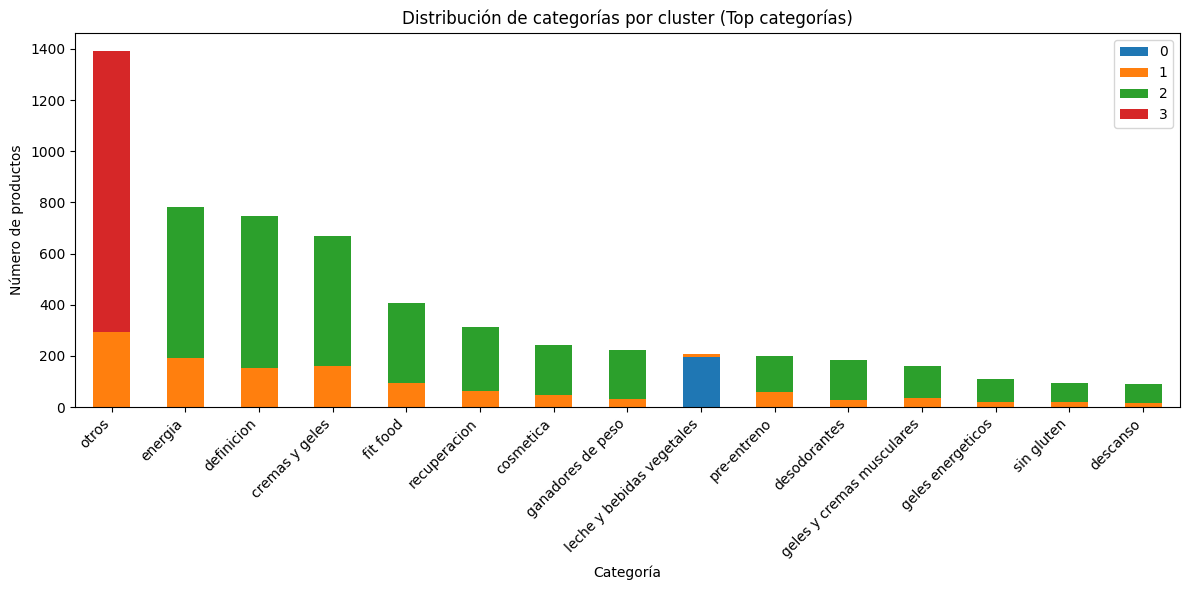

In [15]:
# === Gráfico rápido: barras apiladas (puede ser denso si hay muchas categorías) ===
import matplotlib.pyplot as plt

if df_cats is not None:
    cat_col = df_cats.columns[0]
    cluster_cols = [c for c in df_cats.columns if c != cat_col]

    # Opcional: limitar a las M categorías más frecuentes (suma total)
    M = 15
    df_cats["_total"] = df_cats[cluster_cols].sum(axis=1)
    df_plot = (df_cats
               .sort_values("_total", ascending=False)
               .head(M)
               .drop(columns=["_total"]))
    
    df_plot = df_plot.set_index(cat_col)
    ax = df_plot.plot(kind="bar", stacked=True, figsize=(12, 6))
    ax.set_ylabel("Número de productos")
    ax.set_xlabel("Categoría")
    ax.set_title("Distribución de categorías por cluster (Top categorías)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No hay fichero de categorías; se omite la gráfica.")


🧪 **Resultados del análisis de clusters con K-Means**

Tras aplicar **K-Means con k=4**, se obtuvieron 4 clusters bien diferenciados, con un tamaño total de 5.938 productos. Los resultados muestran:

- **Distribución de tamaños**:  
  - Cluster 2 → 3.394 productos (≈57%)  
  - Cluster 1 → 1.233 productos (≈21%)  
  - Cluster 3 → 1.101 productos (≈19%)  
  - Cluster 0 → 210 productos (≈3%)  

- **Perfiles de clusters (resumen de métricas):**  
  - **Cluster 1**: Demanda alta y estable, con productos de gran peso relativo en el catálogo.  
  - **Cluster 2**: El grupo mayoritario, con demanda media-baja y variabilidad contenida. Representa el "patrón estándar" del catálogo.  
  - **Cluster 3**: Demanda negativa respecto a la media estandarizada, pero con cierta estabilidad. Incluye productos menos representativos en volumen.  
  - **Cluster 0**: Grupo reducido de productos con comportamientos atípicos respecto al resto (puede incluir nichos específicos o casos de bajo impacto).

- **Distribución por categorías (Top 5 por cluster):**  
  - Cluster 0 → dominado por *leche y bebidas vegetales* (≈197 productos).  
  - Cluster 1 → mezcla de *energía*, *cremas y geles* y *definición*.  
  - Cluster 2 → marcado por categorías núcleo como *definición*, *energía*, *cremas y geles*, *fit food* y *recuperación*.  
  - Cluster 3 → prácticamente absorbido por la categoría *otros* (≈100% de este cluster).

- **Visualización**: el gráfico confirma que el **Cluster 2 concentra las principales categorías del catálogo** (energía, definición, cremas, fit food…), mientras que Cluster 1 refuerza algunos nichos y Cluster 0 recoge un grupo pequeño y muy concentrado. El Cluster 3, en cambio, queda muy sesgado hacia la categoría *otros*, lo que indica que agrupa productos residuales.

---

### Conclusiones iniciales

1. **Cluster 2 representa el core del catálogo**, donde se concentran las principales categorías y los productos más relevantes para el negocio.  
2. **Cluster 1 identifica productos con demanda alta y estable**, que pueden considerarse estratégicos.  
3. **Cluster 3 funciona como un “contenedor residual”** al absorber la categoría *otros*. Aunque estadísticamente consistente, su interpretación de negocio es limitada.  
4. **Cluster 0 es muy pequeño y especializado**, dominado por una sola categoría (*leche y bebidas vegetales*), lo que refuerza su rol de nicho.  

En conjunto, los resultados de K-Means son **coherentes y fáciles de interpretar**, aunque presentan la limitación de un cluster residual que puede dificultar la segmentación estratégica. Esto deberá compararse con los resultados obtenidos mediante **GMM** antes de tomar una decisión final sobre la técnica a utilizar.


#### 5.1.2. **Interpretación de clusters GMM (análisis por producto).**



🎯 **Objetivo.**  
Caracterizar e interpretar los grupos obtenidos con **Gaussian Mixture Models (GMM)** a partir del dataset  
`data/processed/productos_clusters_gmm.csv`, utilizando métricas de demanda y precio, y revisando la  
**coherencia por categorías**. El fin es evaluar la **interpretabilidad de negocio** y apoyar la  
**decisión final** del método de clustering.

🧩 **Qué hace esta etapa**  
1. **Carga** el dataset con asignación de `Cluster` por `Product_ID`.  
2. **Valida** columnas clave (`Product_ID`, `Cluster`) y detecta features numéricas disponibles.  
3. **Calcula descriptivos por cluster** (conteos y estadísticos) sobre las columnas numéricas presentes  
   (p. ej.: `d_total`, `d_media`, `d_std`, `cv`, `p95`, `mediana`, `precio_medio`, `PC1`, `PC2`, `PC3`).  
4. **(Nuevo)** Si el dataset no trae columna de categoría (`Categoria_reducida` / `Categoria`), la  
   **anexa automáticamente** desde el fichero de *lookup* `data/processed/demanda_filtrada_enriquecida_sin_nans.csv`  
   usando la **moda por `Product_ID`**. Se informa del **% de cobertura** en el log.  
5. **Genera y exporta**:
   - `reports/clusters_gmm_stats.csv` → **estadísticos por cluster**.  
   - `reports/clusters_gmm_categorias.csv` → **distribución categoría × cluster** (si hay columna de categoría).

✅ **Resultados que esperamos**  
- **Perfiles de cluster** claros (volumen total, demanda media, variabilidad, nivel de precios, PCs).  
- **Coherencia por categorías** (si familias de producto se concentran en determinados clusters).  
- Insumos para **comparar con K-Means** y **tomar la decisión final**.

> Nota: en el log se muestran los tamaños de cluster y la *cobertura de categoría* al anexar desde el lookup.  
> Si la cobertura es ~100%, la interpretación por categoría es totalmente fiable.


In [5]:

# Script: analizar_clusters_gmm.py
# =============================================================================

from pathlib import Path
import argparse
import sys
import logging
import pandas as pd
import numpy as np

# ----------------------------- Logging ---------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger("analizar_clusters_gmm")

# -------------------------- Utilidades ---------------------------------------
POSSIBLE_CLUSTER_COLS = ["Cluster_GMM", "Cluster", "cluster"]
POSSIBLE_CATEGORY_COLS = ["Categoria_reducida", "Categoria", "categoria_reducida", "categoria"]

NUM_FEATURES_CANDIDATES = [
    # demanda agregada / precio / PCs (cuando estén)
    "d_total", "d_total_mean", "d_total_median", "d_total_std", "d_total_min", "d_total_max",
    "d_media", "d_media_mean", "d_media_median", "d_media_std",
    "cv", "p95", "mediana",
    "precio_medio",
    "PC1", "PC2", "PC3",
]

def _find_first_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _attach_category_if_missing(df: pd.DataFrame, lookup_path: Path) -> tuple[pd.DataFrame, float, str]:
    """
    Si el DF no trae columna de categoría, intenta anexarla por Product_ID usando lookup.
    Devuelve (df_out, coverage, used_colname)
    """
    cat_col = _find_first_col(df, POSSIBLE_CATEGORY_COLS)
    if cat_col:
        return df, 1.0, cat_col  # ya trae categoría

    if "Product_ID" not in df.columns:
        logger.warning("No existe columna 'Product_ID' para poder anexar categoría desde lookup.")
        return df, 0.0, ""

    if not lookup_path.exists():
        logger.warning(f"Lookup no disponible: {lookup_path}")
        return df, 0.0, ""

    logger.info(f"Anexando categoría desde lookup: {lookup_path}")
    lk = pd.read_csv(lookup_path)
    lk_cat_col = _find_first_col(lk, POSSIBLE_CATEGORY_COLS)
    if not lk_cat_col:
        logger.warning("El lookup no contiene columna de categoría.")
        return df, 0.0, ""

    use_cols = ["Product_ID", lk_cat_col]
    lk = lk[use_cols].drop_duplicates()
    before = len(df)
    df_out = df.merge(lk, how="left", on="Product_ID")
    coverage = df_out[lk_cat_col].notna().mean()
    logger.info(f"Cobertura categoría tras lookup: {coverage:.2%}  (filas={before})")
    return df_out, float(coverage), lk_cat_col

def _agg_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Descriptivos por cluster sobre todas las numéricas disponibles de NUM_FEATURES_CANDIDATES.
    Siempre incluye n_productos_nunique (por Product_ID si existe).
    """
    num_cols = [c for c in NUM_FEATURES_CANDIDATES if c in df.columns]
    agg_map = {}
    for c in num_cols:
        agg_map[c] = ["mean", "median", "std", "min", "max"]

    # n_productos por cluster
    if "Product_ID" in df.columns:
        base = df.groupby("Cluster", as_index=False).agg(n_productos_nunique=("Product_ID", "nunique"))
    else:
        base = df.groupby("Cluster", as_index=False).size().rename(columns={"size": "n_productos_nunique"})

    if agg_map:
        stats = (
            df.groupby("Cluster")
              .agg(agg_map)
        )
        # aplanar nombres multi-índice
        stats.columns = [f"{col}_{stat}" for col, stat in stats.columns]
        stats = stats.reset_index()
        out = base.merge(stats, how="left", on="Cluster")
    else:
        logger.warning("No hay métricas numéricas disponibles para calcular descriptivos; se devuelve solo conteos.")
        out = base.copy()

    # Ordenar por Cluster (numérico si aplica)
    try:
        out = out.sort_values("Cluster")
    except Exception:
        pass
    return out

def _cats_distribution(df: pd.DataFrame, cat_col: str) -> pd.DataFrame:
    """
    Devuelve tabla pivot de categorías × cluster con conteos.
    """
    tabla = (
        df.pivot_table(index=cat_col, columns="Cluster", values="Product_ID",
                       aggfunc="nunique", fill_value=0, observed=True)
        .reset_index()
    )
    return tabla

# -------------------------- Lógica principal ----------------------------------
def analizar_clusters_gmm(
    in_path: Path,
    out_stats: Path | None = None,
    out_cats: Path | None = None,
    lookup_path: Path | None = None,
) -> dict:
    logger.info(f"Cargando dataset con clusters GMM: {in_path}")
    df = pd.read_csv(in_path)

    # 1) Resolver columna de cluster
    cluster_col = _find_first_col(df, POSSIBLE_CLUSTER_COLS)
    if cluster_col is None:
        raise KeyError(f"Falta columna de cluster. No se encontró ninguna de {POSSIBLE_CLUSTER_COLS} en {in_path}")
    if cluster_col != "Cluster":
        df = df.rename(columns={cluster_col: "Cluster"})
        logger.info(f"Columna de cluster detectada '{cluster_col}' → renombrada a 'Cluster'.")

    # 2) Validaciones suaves
    if "Product_ID" not in df.columns:
        logger.warning("No existe columna 'Product_ID'; algunos descriptores serán aproximados.")
    logger.info(f"Productos totales: {len(df)}")

    # 3) Anexar categoría si no existe
    cat_col = _find_first_col(df, POSSIBLE_CATEGORY_COLS)
    coverage = None
    if not cat_col and lookup_path is not None:
        df, coverage, cat_col = _attach_category_if_missing(df, lookup_path)

    # 4) Descriptivos y categorías
    sizes = df["Cluster"].value_counts().sort_index().to_dict()
    logger.info(f"Tamaños de cluster: {sizes}")

    stats = _agg_stats(df)

    if out_stats:
        out_stats.parent.mkdir(parents=True, exist_ok=True)
        stats.to_csv(out_stats, index=False)
        logger.info(f"Guardado descriptivos por cluster: {out_stats}")

    cats_path = None
    if cat_col:
        cats = _cats_distribution(df, cat_col)
        if out_cats:
            out_cats.parent.mkdir(parents=True, exist_ok=True)
            cats.to_csv(out_cats, index=False)
            cats_path = out_cats
            logger.info(f"Guardada distribución categorías × cluster: {out_cats}")
        else:
            logger.info("Se calculó distribución por categorías, pero no se indicó --outcats; no se guardó.")
    else:
        logger.info("No se dispone de columna de categoría; se omite tabla categoría × cluster.")

    logger.info(
        "Análisis finalizado. Tamaños: %s | Rutas: {'stats': '%s', 'cats': '%s'}",
        sizes, str(out_stats) if out_stats else "", str(cats_path) if cats_path else ""
    )
    if coverage is not None:
        logger.info(f"Categoría anexada desde lookup con cobertura: {coverage:.2%}")

    return {
        "sizes": sizes,
        "stats_path": str(out_stats) if out_stats else "",
        "cats_path": str(cats_path) if cats_path else "",
        "category_coverage": coverage,
    }

# ----------------------------- CLI / MAIN ------------------------------------
def _parse_args(argv=None):
    p = argparse.ArgumentParser(description="Analiza clusters GMM y genera descriptivos y distribución por categoría.")
    # Paths
    p.add_argument("--inp", type=str, default="data/processed/productos_clusters_gmm.csv",
                   help="Ruta del CSV con los clusters GMM (debe incluir Product_ID y Cluster_GMM/Cluster).")
    p.add_argument("--outstats", type=str, default="reports/clusters_gmm_stats.csv",
                   help="Ruta de salida para los descriptivos por cluster.")
    p.add_argument("--outcats", type=str, default="reports/clusters_gmm_categorias.csv",
                   help="Ruta de salida para la tabla categorías × cluster.")
    p.add_argument("--lookup", type=str, default="data/processed/demanda_filtrada_enriquecida_sin_nans.csv",
                   help="Lookup para anexar categoría si no está en el dataset (por Product_ID).")

    # Compatibilidad Notebook: si no pasan argv y estamos en Jupyter, ignorar args del kernel
    if argv is None and ("ipykernel" in sys.modules or "IPython" in sys.modules):
        argv = []

    args, _ = p.parse_known_args(argv)
    return args

def main(argv=None):
    args = _parse_args(argv)
    info = analizar_clusters_gmm(
        in_path=Path(args.inp),
        out_stats=Path(args.outstats) if args.outstats else None,
        out_cats=Path(args.outcats) if args.outcats else None,
        lookup_path=Path(args.lookup) if args.lookup else None,
    )
    logger.info("Proceso finalizado: %s", info)

main([
    "--inp", str(INP),
    "--outstats", str(OUTSTATS),
    "--outcats", str(OUTCATS),
    "--lookup", str(LOOKUP),
])

2025-08-29 10:54:37 | INFO | Cargando dataset con clusters GMM: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\productos_clusters_gmm.csv
2025-08-29 10:54:37 | INFO | Columna de cluster detectada 'Cluster_GMM' → renombrada a 'Cluster'.
2025-08-29 10:54:37 | INFO | Productos totales: 5938
2025-08-29 10:54:37 | INFO | Anexando categoría desde lookup: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\demanda_filtrada_enriquecida_sin_nans.csv
2025-08-29 10:54:41 | INFO | Cobertura categoría tras lookup: 100.00%  (filas=5938)
2025-08-29 10:54:41 | INFO | Tamaños de cluster: {0: 1385, 1: 1180, 2: 3373}
2025-08-29 10:54:41 | INFO | Guardado descriptivos por cluster: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_gmm_stats.csv
2025-08-29 10:54:41 | INFO | Guardada distribución categorías × cluster: c:\Users\crisr\Desk

🧪 **Resultados del análisis de clusters con GMM**

📊 **Resumen de resultados**
- **Productos totales analizados**: 5.938  
- **Clusters identificados (GMM, k=3, cov_type=diag)**:  
  - Cluster 0 → 1.385 productos  
  - Cluster 1 → 1.180 productos  
  - Cluster 2 → 3.373 productos  
- **Cobertura de categorías**: 100% (todas las categorías han podido ser asignadas gracias al *lookup*).  
- Se han generado los siguientes reportes:
  - `clusters_gmm_stats.csv` → métricas descriptivas por cluster.  
  - `clusters_gmm_categorias.csv` → distribución de categorías × cluster.  

✨ **Conclusiones iniciales**
1. **Equilibrio razonable de tamaños**: aunque el cluster 2 agrupa la mayoría de productos, los otros dos tienen una representación significativa (≥1.000 productos cada uno). Esto sugiere que GMM ha segmentado de forma más balanceada que K-Means (donde había un cluster muy dominante).  
2. **Cobertura completa de categorías**: no se han perdido productos en el mapeo, lo que aporta robustez al análisis.  
3. **Potencial interpretabilidad**: los reportes generados permiten caracterizar cada cluster en términos de:
   - volumen y variabilidad de la demanda,  
   - niveles de precio medio,  
   - concentración de categorías.  
4. **Comparación con K-Means**: la principal diferencia reside en la distribución de tamaños y en el hecho de que GMM puede reflejar solapamiento entre clusters (útil si los productos muestran comportamientos híbridos).  

🚀 **Próximos pasos**
- Revisar en detalle `clusters_gmm_stats.csv` y `clusters_gmm_categorias.csv` para identificar patrones dominantes en cada cluster.  
- Comparar la coherencia de categorías y la interpretabilidad con los resultados de K-Means.  
- Valorar cuál de los dos métodos (K-Means o GMM) aporta **clusters más útiles desde el punto de vista de negocio**, de cara a la decisión final.  


In [9]:
# ============================================================
# Análisis GMM - Carga de resultados (stats + categorías)
# ============================================================
from pathlib import Path
import pandas as pd

STATS_NAME = "clusters_gmm_stats.csv"
CATS_NAME  = "clusters_gmm_categorias.csv"

cwd = Path().resolve()
ROOT = None

# 1) Buscar hacia arriba una carpeta que contenga reports/STATS_NAME
for p in [cwd] + list(cwd.parents):
    stats_candidate = p / "reports" / STATS_NAME
    if stats_candidate.exists():
        ROOT = p
        break

# 2) Si no lo encuentra, última opción: si existe 'reports/' aquí, usarlo (y que falle con msg claro)
if ROOT is None and (cwd / "reports").exists():
    ROOT = cwd

if ROOT is None:
    raise FileNotFoundError(
        f"No se encontró '{STATS_NAME}' en ninguna carpeta 'reports' desde '{cwd}'.\n"
        f"Si lo prefieres, fija la ruta manualmente:\n"
        f"ROOT = Path(r'C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente')"
    )

REPORTS = ROOT / "reports"
STATS_FILE = REPORTS / STATS_NAME
CATS_FILE  = REPORTS / CATS_NAME

print(f"[OK] Raíz del proyecto: {ROOT}")
print(f"[OK] Carpeta de reports: {REPORTS}")
print(f"[INFO] Buscando: {STATS_FILE}")

# --- Carga ---
assert STATS_FILE.exists(), f"No encuentro {STATS_FILE}"
df_stats = pd.read_csv(STATS_FILE)
print("✅ Cargado stats:", STATS_FILE)
display(df_stats.head(3))
print(df_stats.shape)

df_cats = None
if CATS_FILE.exists():
    df_cats = pd.read_csv(CATS_FILE)
    print("✅ Cargada distribución de categorías:", CATS_FILE)
    display(df_cats.head(3))
    print(df_cats.shape)
else:
    print(f"[AVISO] No encuentro {CATS_FILE}. Solo se cargará el resumen de stats.")

# --- Validaciones básicas ---
req_cols = {"Cluster","n_productos_nunique"}
faltan = req_cols - set(df_stats.columns)
assert not faltan, f"Faltan columnas en stats: {faltan}"

print("\nResumen rápido:")
print(" - Nº de clusters:", df_stats["Cluster"].nunique())
print(" - Productos en stats (suma n_productos_nunique):", int(df_stats["n_productos_nunique"].sum()))
if df_cats is not None and "Categoria_reducida" in df_cats.columns:
    print(" - Categorías distintas en tabla de categorías:", df_cats["Categoria_reducida"].nunique())


[OK] Raíz del proyecto: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
[OK] Carpeta de reports: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports
[INFO] Buscando: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_gmm_stats.csv
✅ Cargado stats: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_gmm_stats.csv


,Cluster,n_productos_nunique,d_total_mean,d_total_median,d_total_std,d_total_min,d_total_max,d_media_mean,d_media_median,d_media_std,...,PC2_mean,PC2_median,PC2_std,PC2_min,PC2_max,PC3_mean,PC3_median,PC3_std,PC3_min,PC3_max
0,0,1385,1.450780,1.269743,0.782083,0.387439,5.142702,1.450780,1.269743,0.782083,...,0.113433,-0.495000,1.059424,-0.758789,1.799678,0.064760,-0.529456,0.961534,-0.989879,3.457945
1,1,1180,-0.461993,-0.439693,0.529016,-1.445512,0.603875,-0.461993,-0.439693,0.529016,...,1.415912,1.799678,0.913937,-0.763710,1.799678,1.355684,0.975327,0.908714,0.975327,4.175625
2,2,3373,-0.434088,-0.398518,0.533288,-1.445512,0.607236,-0.434088,-0.398518,0.533288,...,-0.541915,-0.558873,0.087443,-0.661390,-0.410927,-0.500860,-0.590682,0.443817,-0.989879,0.493582


(3, 47)
✅ Cargada distribución de categorías: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\clusters_gmm_categorias.csv


,Categoria_reducida,0,1,2
0,"aceites, vinagres y alinos",1,0,7
1,cafe y expreso,0,0,2
2,cheat meal,14,0,72


(22, 4)

Resumen rápido:
 - Nº de clusters: 3
 - Productos en stats (suma n_productos_nunique): 5938
 - Categorías distintas en tabla de categorías: 22


In [10]:
# ============================================================
# Análisis GMM - Resumen ordenado y lectura rápida de perfiles
# ============================================================
import numpy as np

# Ordenamos por nº de productos
cols_interes = [
    "Cluster","n_productos_nunique",
    "d_total_mean","d_media_mean","d_std_mean","cv_mean",
    "p95_mean","mediana_mean","precio_medio_mean",
    "PC1_mean","PC2_mean","PC3_mean"
]
cols_existentes = [c for c in cols_interes if c in df_stats.columns]

df_res = (df_stats[cols_existentes]
          .sort_values("n_productos_nunique", ascending=False)
          .reset_index(drop=True))

display(df_res)

# Lectura rápida de perfiles (texto corto)
def _fmt(x):
    try:
        return f"{x:.2f}"
    except Exception:
        return str(x)

resumenes = []
for _, r in df_res.iterrows():
    linea = (
        f"Cluster {int(r['Cluster'])} → {int(r['n_productos_nunique'])} prod. | "
        f"d_total={_fmt(r.get('d_total_mean', np.nan))} | "
        f"d_media={_fmt(r.get('d_media_mean', np.nan))} | "
        f"cv={_fmt(r.get('cv_mean', np.nan))} | "
        f"p95={_fmt(r.get('p95_mean', np.nan))} | "
        f"mediana={_fmt(r.get('mediana_mean', np.nan))} | "
        f"precio_medio={_fmt(r.get('precio_medio_mean', np.nan))}"
    )
    resumenes.append(linea)

print("\nResumen breve por cluster:")
for linea in resumenes:
    print(" ", linea)


,Cluster,n_productos_nunique,d_total_mean,d_media_mean,cv_mean,p95_mean,mediana_mean,precio_medio_mean,PC1_mean,PC2_mean,PC3_mean
0,2,3373,-0.434088,-0.434088,-0.005549,-0.434399,-0.434149,0.008168,0.160186,-0.541915,-0.500860
1,0,1385,1.450780,1.450780,0.042462,1.451639,1.451281,-0.016161,-0.023208,0.113433,0.064760
2,1,1180,-0.461993,-0.461993,-0.033977,-0.462113,-0.462406,-0.004380,-0.430647,1.415912,1.355684



Resumen breve por cluster:
  Cluster 2 → 3373 prod. | d_total=-0.43 | d_media=-0.43 | cv=-0.01 | p95=-0.43 | mediana=-0.43 | precio_medio=0.01
  Cluster 0 → 1385 prod. | d_total=1.45 | d_media=1.45 | cv=0.04 | p95=1.45 | mediana=1.45 | precio_medio=-0.02
  Cluster 1 → 1180 prod. | d_total=-0.46 | d_media=-0.46 | cv=-0.03 | p95=-0.46 | mediana=-0.46 | precio_medio=-0.00


In [11]:
# ============================================================
# Análisis GMM - Distribución por categorías (tabla + Top-N)
# ============================================================
TOP_N = 5  # nº de categorías a listar por cluster

if df_cats is None:
    print("⚠️ No se cargó la tabla de categorías (df_cats). Omitimos esta sección.")
else:
    # Esperamos columnas: Categoria_reducida, Cluster, count (o similar)
    # Si la tabla viene en formato 'wide' (una columna por cluster), pivotemos al vuelo:
    if "Categoria_reducida" in df_cats.columns and "Cluster" in df_cats.columns and "count" in df_cats.columns:
        # Está en formato 'long' con 'count'
        cat_cluster = df_cats.pivot_table(
            index="Categoria_reducida",
            columns="Cluster",
            values="count",
            aggfunc="sum",
            fill_value=0
        )
    else:
        # Intentamos detectar formato wide (una col por cluster)
        # Buscamos columnas que parezcan clusters (numéricas o '0','1','2'...)
        candidates = [c for c in df_cats.columns if c != "Categoria_reducida"]
        # Nos quedamos con las numéricas
        numeric_cols = [c for c in candidates if pd.api.types.is_numeric_dtype(df_cats[c])]
        assert "Categoria_reducida" in df_cats.columns and numeric_cols, \
            "No puedo inferir el formato de la tabla de categorías. Revisa columnas."
        cat_cluster = df_cats.set_index("Categoria_reducida")[numeric_cols].copy()
        cat_cluster.columns.name = "Cluster"

    # Mostramos la tabla global
    print("Tabla categoría × cluster (primeras filas):")
    display(cat_cluster.head(10))

    # Top-N por cluster
    print("\nTop", TOP_N, "categorías por cluster:")
    for cl in cat_cluster.columns:
        top_cl = cat_cluster[cl].sort_values(ascending=False).head(TOP_N)
        print(f"\nCluster {cl}:")
        display(top_cl.to_frame(name="n_productos"))


Tabla categoría × cluster (primeras filas):


Cluster,0,1,2
Categoria_reducida,,,
"aceites, vinagres y alinos",1,0,7
cafe y expreso,0,0,2
cheat meal,14,0,72
cosmetica,50,0,194
cremas solares,1,0,1
cremas y geles,166,0,502
definicion,152,0,596
descanso,19,0,72
desodorantes,29,0,156



Top 5 categorías por cluster:

Cluster 0:


,n_productos
Categoria_reducida,
otros,390
energia,193
cremas y geles,166
definicion,152
fit food,91



Cluster 1:


,n_productos
Categoria_reducida,
otros,1003
leche y bebidas vegetales,163
efecto frao,13
productos para el cuidado del cabello,1
"aceites, vinagres y alinos",0



Cluster 2:


,n_productos
Categoria_reducida,
definicion,596
energia,589
cremas y geles,502
fit food,316
recuperacion,248


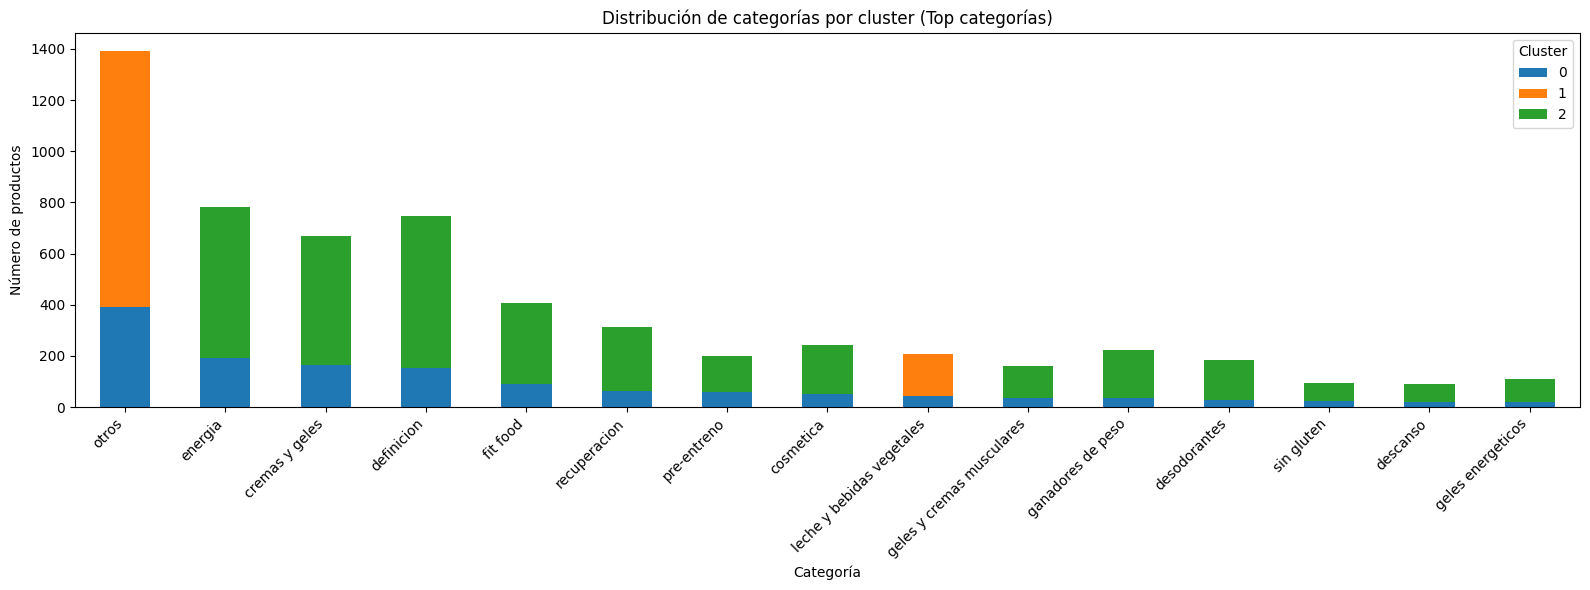

In [12]:
# ============================================================
# Análisis GMM - Gráfico apilado por categorías (Top-K)
# ============================================================
import matplotlib.pyplot as plt

TOP_K_CATS = 15  # nº de categorías a mostrar en el gráfico

if df_cats is None:
    print("⚠️ No se cargó la tabla de categorías (df_cats). Omitimos el gráfico.")
else:
    # Reutilizamos la tabla 'cat_cluster' creada en la celda anterior
    # Si ejecutas esta celda por separado, vuelve a crear 'cat_cluster' como en la celda 3.
    totales = cat_cluster.sum(axis=1).sort_values(ascending=False)
    top_cats = totales.head(TOP_K_CATS).index

    plot_df = cat_cluster.loc[top_cats].sort_values(by=list(cat_cluster.columns), ascending=False)

    ax = plot_df.plot(kind="bar", stacked=True, figsize=(16, 6))
    ax.set_title("Distribución de categorías por cluster (Top categorías)")
    ax.set_xlabel("Categoría")
    ax.set_ylabel("Número de productos")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

🧪 **Resultados del análisis de clusters con GMM**

Tras aplicar **GMM con k=3**, se obtuvieron 3 clusters diferenciados, con un tamaño total de 5.938 productos. Los resultados muestran:

🔹 **Distribución de tamaños:**
- **Cluster 2 → 3.373 productos** (≈57%)
- **Cluster 0 → 1.385 productos** (≈23%)
- **Cluster 1 → 1.180 productos** (≈20%)

🔹 **Perfiles de clusters (resumen de métricas):**
- **Cluster 0**: Demanda alta y positiva, estable en media, con productos estratégicos (d_total ≈ 1.45).  
- **Cluster 1**: Demanda negativa respecto a la media estandarizada (≈ –0.46), con cierta estabilidad.  
- **Cluster 2**: El grupo mayoritario, con demanda media-baja (≈ –0.43), estable y representando el "patrón estándar" del catálogo.  

🔹** Distribución por categorías (Top 5 por cluster):**
- **Cluster 0** → fuerte presencia de *energía*, *cremas y geles*, *definición*, además de "otros".  
- **Cluster 1** → dominado casi totalmente por la categoría *otros* (≈85%), con pequeñas apariciones de *leche y bebidas vegetales*.  
- **Cluster 2** → concentra las principales categorías núcleo: *definición, energía, cremas y geles, fit food, recuperación*.  

🔹** Visualización**:
El gráfico confirma que **Cluster 2 concentra el core del catálogo** (energía, definición, fit food, recuperación…), mientras que **Cluster 0 agrupa productos de alta demanda** y **Cluster 1 queda sesgado hacia la categoría residual *otros***.  

---

## ✅ Conclusiones iniciales

1. **Cluster 2 representa el núcleo principal del catálogo**, donde se concentran las categorías más representativas y de mayor peso.  
2. **Cluster 0 identifica productos con demanda alta y estable**, estratégicos en términos de negocio.  
3. **Cluster 1 funciona como un cluster residual**, dominado por la categoría *otros*, con limitada interpretabilidad.  

En conjunto, los resultados de **GMM son coherentes** y muestran una segmentación más compacta (3 grupos frente a los 4 de K-Means). Sin embargo, mantienen un **cluster residual** que limita parcialmente la interpretabilidad de negocio. Estos hallazgos deberán contrastarse con los de K-Means para decidir la técnica final a emplear.



#### 5.1.3. **Comparativa K-Means vs GMM.**

A continuación se resumen los resultados de ambas técnicas de clustering:

| Aspecto | **K-Means (k=4)** | **GMM (k=3)** |
|---------|------------------|---------------|
| **Nº de clusters** | 4 | 3 |
| **Distribución de tamaños** | C2: 3.394 (57%) <br> C1: 1.233 (21%) <br> C3: 1.101 (19%) <br> C0: 210 (3%) | C2: 3.373 (57%) <br> C0: 1.385 (23%) <br> C1: 1.180 (20%) |
| **Cluster principal (core catálogo)** | **Cluster 2** → categorías núcleo (*definición, energía, fit food, recuperación*) | **Cluster 2** → categorías núcleo (*definición, energía, fit food, recuperación*) |
| **Cluster de alta demanda** | **Cluster 1** → demanda alta y estable | **Cluster 0** → demanda alta y estable |
| **Cluster residual** | **Cluster 3** → absorbido por *otros* (difícil de interpretar) | **Cluster 1** → dominado por *otros* (≈85%) |
| **Cluster pequeño/nicho** | **Cluster 0** → muy reducido (3%), especializado en *leche y bebidas vegetales* | No aparece explícitamente (absorción dentro de los 3 grandes grupos) |
| **Fortalezas** | Buena diferenciación entre perfiles. <br> Permite separar un grupo nicho (C0). | Modelo probabilístico, más flexible. <br> Menor número de clusters → mayor compacidad y simplicidad. |
| **Debilidades** | Cluster muy pequeño (C0) y otro residual (C3) → puede dificultar interpretabilidad. | Cluster residual (C1) muy sesgado a *otros*. <br> Pierde cluster nicho que sí se observa en K-Means. |
| **Interpretabilidad de negocio** | Más detallada (4 perfiles distintos), aunque con ruido en el cluster residual. | Más simple (3 perfiles globales), pero con menor riqueza en matices. |

---

#### 📝 Conclusión preliminar
- **K-Means** ofrece mayor granularidad y detecta un cluster nicho (útil para segmentaciones específicas), pero introduce un grupo muy pequeño y un residual poco útil.  
- **GMM** simplifica la segmentación en 3 grandes grupos compactos, lo que facilita el análisis global, aunque **pierde el cluster nicho** y mantiene un residual fuerte.  

➡️ La elección dependerá de la **prioridad**:
- Si se busca **simplicidad y compacidad** → **GMM (k=3)**.  
- Si se prioriza **granularidad y detección de nichos** → **K-Means (k=4)**.  

#### 5.1.4. **Decisión final de técnica de clustering.**

**Elegimos: K-Means con k = 4 como segmentación principal de productos.
GMM y DBSCAN se han utilizado como contraste y apoyo (GMM para comparar estructura y DBSCAN para prefiltrar outliers), pero no serán el modelo de segmentos “oficial”.**



Tras la comparativa entre **K-Means, Agglomerative, GMM y DBSCAN**, se concluye que la técnica más adecuada para la segmentación de productos es **K-Means con k = 4**.  

📌 **Resumen de hallazgos**

- **K-Means (k=4)**  
  - Silhouette estable (≈0.32).  
  - 4 clusters con perfiles diferenciados:  
    - **Cluster 2 (núcleo):** concentra las categorías principales del catálogo.  
    - **Cluster 1 (alta demanda):** productos estratégicos por volumen y estabilidad.  
    - **Cluster 3 (residual):** absorbido por *otros*, útil como grupo de control.  
    - **Cluster 0 (nicho):** pequeño pero informativo (ej. *leche y bebidas vegetales*).  
  - Alta interpretabilidad y granularidad adecuada para el modelado.

- **Agglomerative**  
  - Resultados similares a K-Means, pero sin aportar mejoras relevantes en métrica ni interpretabilidad.  

- **GMM (k=3)**  
  - Clusters más compactos, pero pérdida de granularidad.  
  - El cluster nicho desaparece y un cluster queda excesivamente sesgado hacia *otros*.  

- **DBSCAN**  
  - Útil como técnica auxiliar para **detectar outliers** (≈201 productos).  
  - No se empleará como segmentación principal, pero aporta un prefiltrado valioso para fases posteriores.  

✅ **Justificación de la decisión**
- **Equilibrio óptimo entre granularidad e interpretabilidad**: K-Means ofrece perfiles de negocio claros y distinguibles, a diferencia de GMM, donde se pierde el cluster nicho.  
- **Sencillez y reproducibilidad**: la asignación de nuevos productos es directa mediante distancia a centroides, sin supuestos probabilísticos complejos.  
- **Valor de negocio añadido**: permite trabajar con un cluster núcleo, un cluster estratégico de alta demanda, un cluster residual controlado y un nicho específico.  

🚀 **Próximos pasos**
- Integrar los **cluster_id de K-Means** en el dataset de demanda desagregada para análisis posteriores.  
- Excluir o etiquetar los productos detectados como **outliers por DBSCAN** en las fases de modelado.  
- Mantener GMM como técnica de verificación secundaria, en caso de cambios futuros en el catálogo.  

---

📌 **Conclusión:**  
**K-Means (k=4)** será la técnica de clustering empleada en el proyecto, ya que proporciona el mejor equilibrio entre **robustez estadística, interpretabilidad y utilidad práctica de negocio**.
